In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import json
import os

In [2]:
filepath = 'indian-national-level-election.csv'
df = pd.read_csv(filepath)
df.columns


Index(['st_name', 'year', 'pc_no', 'pc_name', 'pc_type', 'cand_name',
       'cand_sex', 'partyname', 'partyabbre', 'totvotpoll', 'electors'],
      dtype='object')

In [3]:
df['st_name'].unique()

array(['Andaman & Nicobar Islands', 'Andhra Pradesh', 'Arunachal Pradesh',
       'Assam', 'Bihar', 'Chandigarh', 'Chattisgarh', 'Chhattisgarh',
       'Dadra & Nagar Haveli', 'Daman & Diu', 'Delhi', 'Goa',
       'Goa Daman & Diu', 'Goa, Daman & Diu', 'Gujarat', 'Haryana',
       'Himachal Pradesh', 'Jammu & Kashmir', 'Jharkhand', 'Karnataka',
       'Kerala', 'Lakshadweep', 'Madhya Pradesh', 'Maharashtra',
       'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
       'National Capital Territory Of Delhi', 'Nct Of Delhi', 'Odisha',
       'Orissa', 'Pondicherry', 'Puducherry', 'Punjab', 'Rajasthan',
       'Sikkim', 'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'Uttarakhand',
       'Uttaranchal', 'West Bengal'], dtype=object)

In [4]:
import pandas as pd

def abbreviate(name):
    parts = name.split()
    if len(parts) > 1:
        abbreviation = "".join([word[0] for word in parts])
        abbreviation = abbreviation.replace("(", "")
    else:
        abbreviation = name
    return abbreviation

def merge(name):
    parts = name.split()
    if len(parts) > 1:
        abbreviation = "".join([word[0] for word in parts])
        abbreviation = abbreviation.replace("(", " ")
        abbreviation = abbreviation.split()[0]
    else:
        if '(' in name:
            abbreviation = name.replace("(", " ")
            abbreviation = abbreviation.split()[0]
        else:
            abbreviation = name
    return abbreviation

def total_votes(state_name, data):
    state_data = data[data['st_name'] == state_name]
    result = {}

    grouped_data = state_data.groupby(['year', 'pc_no'])
    for (year, pc_no), group in grouped_data:
        
        if year not in result:
            result[year] = {}
            
        total_votes_by_party = group.groupby('partyabbre')['totvotpoll'].sum().to_dict()
        result[year][pc_no] = total_votes_by_party
    
    return result

def select_top_partyabbre(ratio_data, **kwargs):
    top_parties_result = {}
    
    alliance = kwargs.get('alliance', None)
    upa, exit_upa = None, None
    nda, exit_nda = None, None
    if alliance is not None:
        upa, exit_upa = alliance.get('upa')
        nda, exit_nda = alliance.get('nda')
    
    for year, ac_nos in ratio_data.items():
        top_parties_result[year] = {}
    
        for pc_no, parties_ratio in ac_nos.items():
            top_parties = sorted(parties_ratio.items(), key=lambda x: x[1], reverse=True)[:5]
            top_parties_result[year][pc_no] = dict(top_parties)
    
    
    for year, ac_nos in top_parties_result.items():
        for ac_no, party_votes in ac_nos.items():
            nda_tally = 0
            upa_tally = 0
            keys_to_remove = []
            for party, votes in party_votes.items():
                if party in nda:
                    nda_tally += votes
                    keys_to_remove.append(party)
                    if party in exit_nda:
                        if int(year) >= exit_nda[party]:
                            nda_tally -= votes
                            keys_to_remove = keys_to_remove[:-1]
                if party in upa:
                    upa_tally += votes
                    keys_to_remove.append(party)
                    if party in exit_upa:
                        if int(year) >= exit_upa[party]:
                            upa_tally -= votes
                            keys_to_remove = keys_to_remove[:-1]
            party_votes.update({'NDA':nda_tally})
            party_votes.update({'UPA':upa_tally})
            
            #print(keys_to_remove)
            for key in keys_to_remove:
                party_votes.pop(key, None)
            
        top_parties_result[year][ac_no] = party_votes
    
    
    return top_parties_result

def aggregate_and_ratio_per_party(ratio_data, **kwargs):
    aggregated_parties_result = {}

    for year, ac_nos in ratio_data.items():
        year_aggregate = {}
        total_votes_year = 0

        # Sum votes for each party across all ac_nos in the year
        for pc_no, parties_ratio in ac_nos.items():
            for party, votes in parties_ratio.items():
                year_aggregate[party] = year_aggregate.get(party, 0) + votes
                total_votes_year += votes  # Accumulate total votes for the year

        
        ordered_aggregate = {}
        for party, total_votes in year_aggregate.items():
            if total_votes_year > 0:
                proportion = round(total_votes / total_votes_year, 4)
            else:
                proportion = 0
            
            if proportion > 0.05:
                ordered_aggregate[party] = [total_votes, proportion]

        aggregated_parties_result[year] = ordered_aggregate

    return aggregated_parties_result



In [5]:
class DataPipeline:
    def __init__(self, root):
        csv = os.path.join(root, "indian-national-level-election.csv")
        nda = os.path.join(root, "NDA.txt")
        upa = os.path.join(root, "UPA.txt")
        states = os.path.join(root, "states.txt")
        exit_nda = os.path.join(root, "exit_NDA.json")
        exit_upa = os.path.join(root, "exit_UPA.json")
        
        self.df = pd.read_csv(csv)
        self.states = self.read_file(states)
        self.upa = self.read_file(upa)
        self.nda = self.read_file(nda)
        self.exit_upa = self.read_file(exit_upa)
        self.exit_nda = self.read_file(exit_nda)
        
        print(f"UPA:{self.upa}")
        print(f"NDA:{self.nda}")

        
        self.df['year'] = self.df['year'].replace(2005.1, 2005)
        self.df['year'] = self.df['year'].astype(int)
        self.df['totvotpoll'] = self.df['totvotpoll'].replace([np.inf, np.nan], 0)
        self.df['totvotpoll'] = self.df['totvotpoll'].astype(int)
        self.df['partyabbre'] = self.df['partyabbre'].replace([np.inf, np.nan], "")
    
    def read_file(self, path):
        if path.endswith('.txt'):
            with open(path, 'r') as f:
                parties = f.readlines()
                parties = [party.strip() for party in parties]
            return parties
        
        if path.endswith('.json'):
            out = {}
            with open(path, 'r') as f:
                js = json.load(f)
                for year, parties in js.items():
                    for party in parties:
                        out.update({party:int(year)})
            return out
                    
    
    def clean_pipeline(self, transforms):
        for func in transforms:
            self.df['partyabbre'] = self.df['partyabbre'].apply(func)

    def total_votes(self, state_name):
        state_data = self.df[self.df['st_name'] == state_name]
        # print(state_data)
        result = {}

        grouped_data = state_data.groupby(['year', 'pc_no'])
        for (year, pc_no), group in grouped_data:
            
            if year not in result:
                result[year] = {}
                
            total_votes_by_party = group.groupby('partyabbre')['totvotpoll'].sum().to_dict()
            result[year][pc_no] = total_votes_by_party
        
        return result
    
    def process_pipeline(self, transforms):
        tot_votesofparties_per_state = {}
        for state in self.states:
            temp = self.total_votes(state)
            tot_votesofparties_per_state.update({state: temp})

        results = {}
        alliance = {
            'upa':[self.upa, self.exit_upa],
            'nda':[self.nda, self.exit_nda]
        }
        for state in self.states:
            temp = tot_votesofparties_per_state[state]
            for func in transforms:
                temp = func(temp, alliance=alliance)

            results.update({state:temp})

        return results

project_root = "D:\Folders\OSU\SP24\CS-5544-DV\Project-Main\DataViz_FinalProject"
#file_path = "indian-national-level-election.csv"
data_pipe = DataPipeline(project_root)

data_pipe.clean_pipeline([abbreviate, merge])

results = data_pipe.process_pipeline([select_top_partyabbre, aggregate_and_ratio_per_party])

 


UPA:['INC', 'DMK', 'NCP', 'RJD', 'IUML', 'JKNC', 'JMM', 'MDMK', 'RSP', 'VCK', 'AJP', 'GFP', 'KC', 'RMP', 'RMPI', 'AGM', 'NCK', 'PWPI']
NDA:['BJP', 'NPP', 'AJSUP', 'AINRC', 'ADS', 'AAGP', 'HSPDP', 'IPFT', 'JDS', 'JDU', 'LJPRV', 'MGP', 'NPF', 'NCP', 'NDPP', 'RLJP', 'SHS', 'SKM', 'TDP', 'TMP', 'UDP', 'UPPL', 'AMNK', 'BDJS', 'GNLF', 'HLP', 'HAM', 'JSS', 'JSP', 'KKC', 'NP', 'PJP', 'PMK', 'PNK', 'RLD', 'RLM', 'RSP', 'RPIA', 'SBSP', 'TMCM']


In [6]:
results

{'Andaman & Nicobar Islands': {1977: {'IND': [25168, 0.4155],
   'UPA': [35400, 0.5845]},
  1980: {'IND': [18088, 0.2293],
   'CPM': [16014, 0.203],
   'UPA': [42046, 0.5329]},
  1984: {'LKD': [27883, 0.3134],
   'CPM': [11086, 0.1246],
   'UPA': [47019, 0.5285]},
  1989: {'CPM': [34469, 0.3049],
   'ICS': [19172, 0.1696],
   'IND': [6041, 0.0534],
   'UPA': [53383, 0.4721]},
  1991: {'CPM': [47374, 0.4414], 'UPA': [54075, 0.5039]},
  1996: {'CPM': [18363, 0.1432],
   'NDA': [31097, 0.2425],
   'UPA': [74642, 0.5822]},
  1998: {'ICS': [29687, 0.2036],
   'CPM': [8272, 0.0567],
   'NDA': [51821, 0.3553],
   'UPA': [52365, 0.3591]},
  1999: {'NDA': [77906, 0.5307], 'UPA': [63959, 0.4357]},
  2004: {'NDA': [57658, 0.3778], 'UPA': [88158, 0.5776]},
  2009: {'NDA': [79907, 0.473], 'UPA': [81833, 0.4844]},
  2014: {'NDA': [90969, 0.4953], 'UPA': [83157, 0.4528]}},
 'Andhra Pradesh': {1977: {'BLD': [5400643, 0.3233], 'UPA': [9582708, 0.5736]},
  1980: {'JNP': [3658365, 0.2164],
   'IND': [128

In [7]:
# Converting int64 keys to string
def convert_keys_to_string(dictionary):
    if isinstance(dictionary, dict):
        return {str(key): convert_keys_to_string(value) for key, value in dictionary.items()}
    elif isinstance(dictionary, list):
        return [convert_keys_to_string(element) for element in dictionary]
    else:
        return dictionary

# Define the output file path
output_file = "results.json"

# Convert the dictionary keys to string
results_str_keys = convert_keys_to_string(results)

# Convert the dictionary to JSON format
json_data = json.dumps(results_str_keys, indent=8)

# Write the JSON data to a file
with open(output_file, "w") as json_file:
    json_file.write(json_data)

print(f"JSON data has been written to {output_file}")

JSON data has been written to results.json


{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


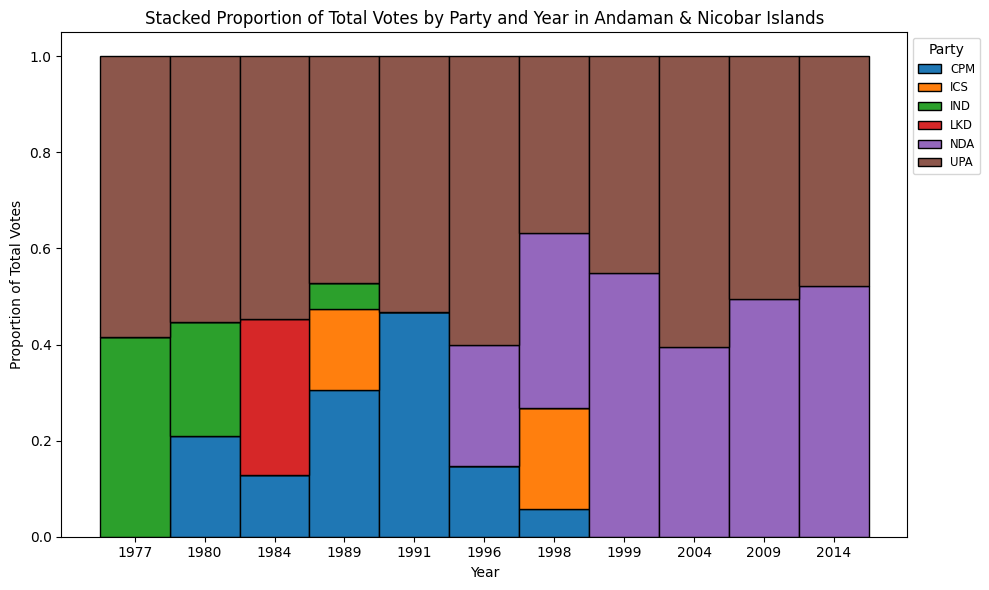

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


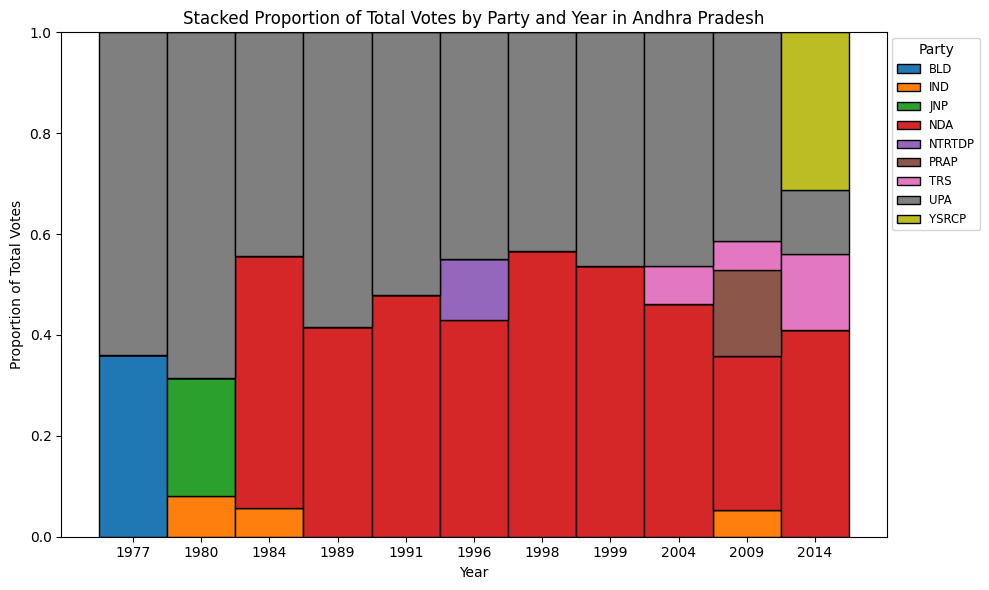

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


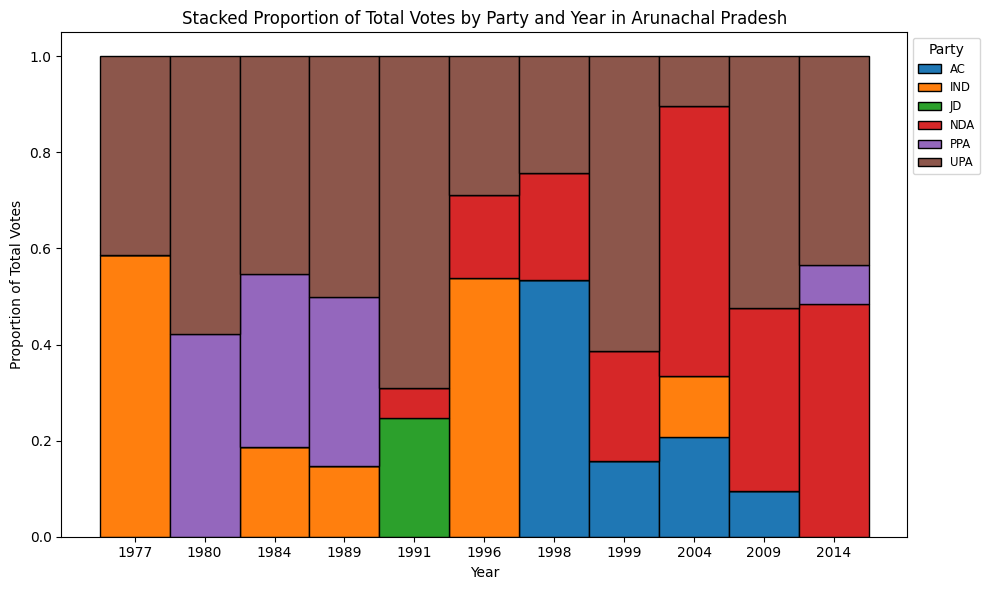

{0: '1977', 1: '1980', 2: '1984', 3: '1991', 4: '1996', 5: '1998', 6: '1999', 7: '2004', 8: '2009', 9: '2014'}


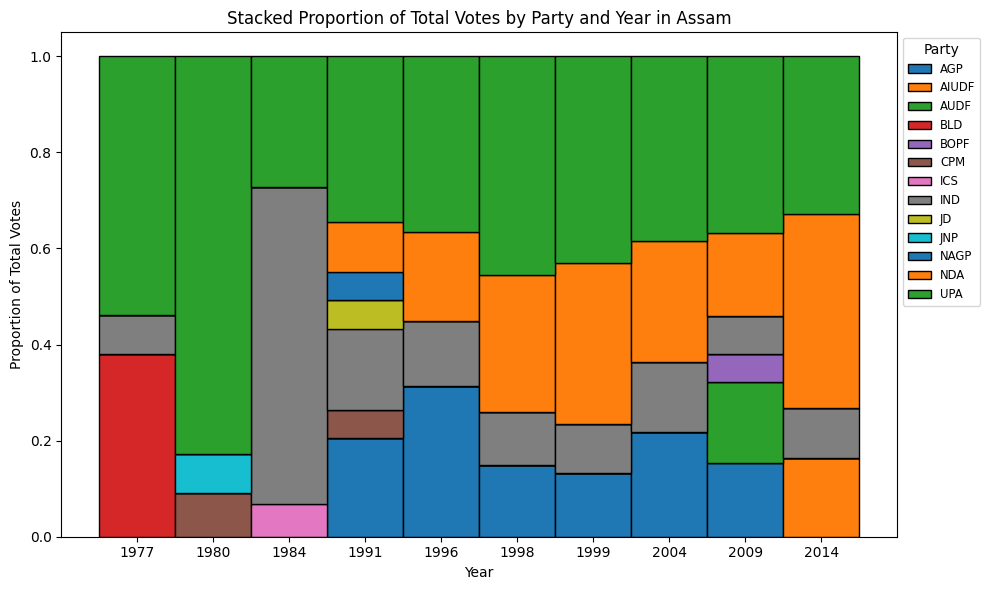

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


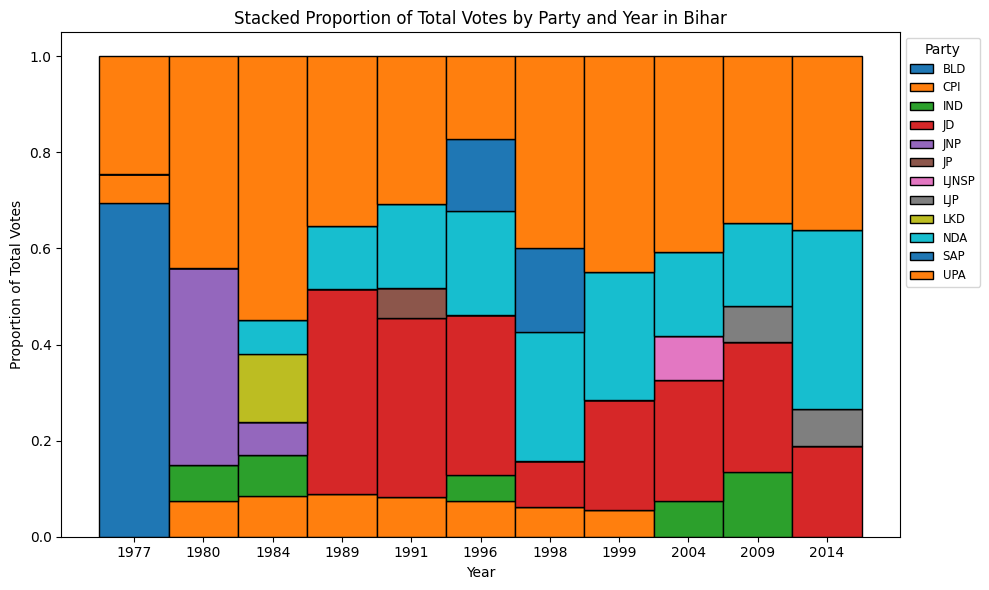

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


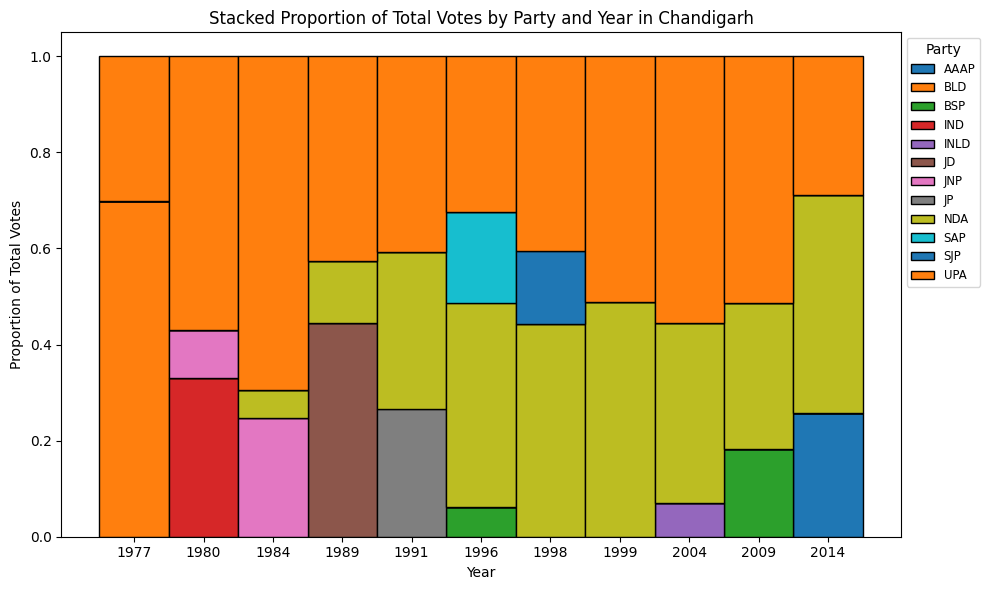

{0: '2009'}


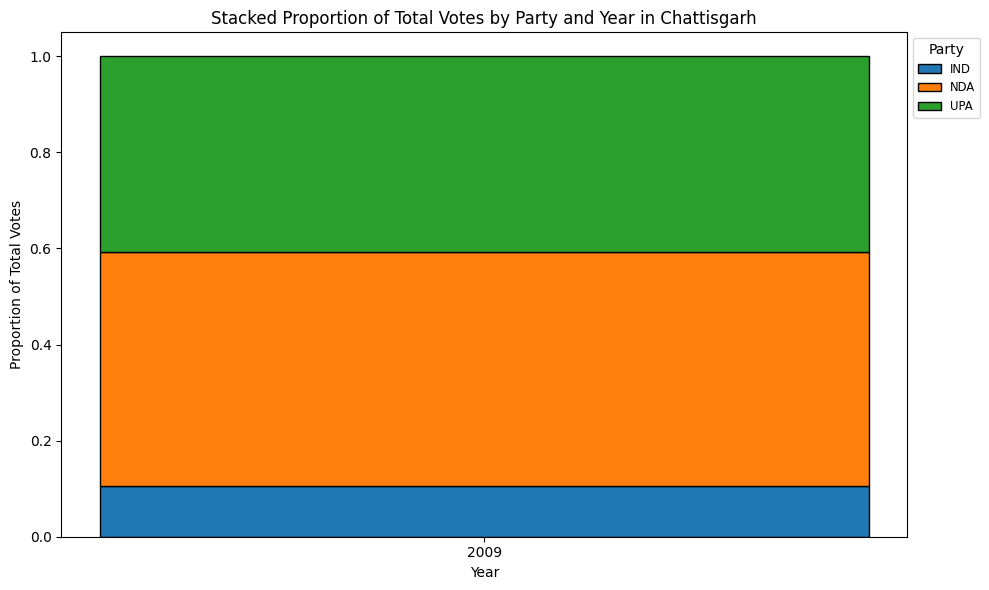

{0: '2004', 1: '2014'}


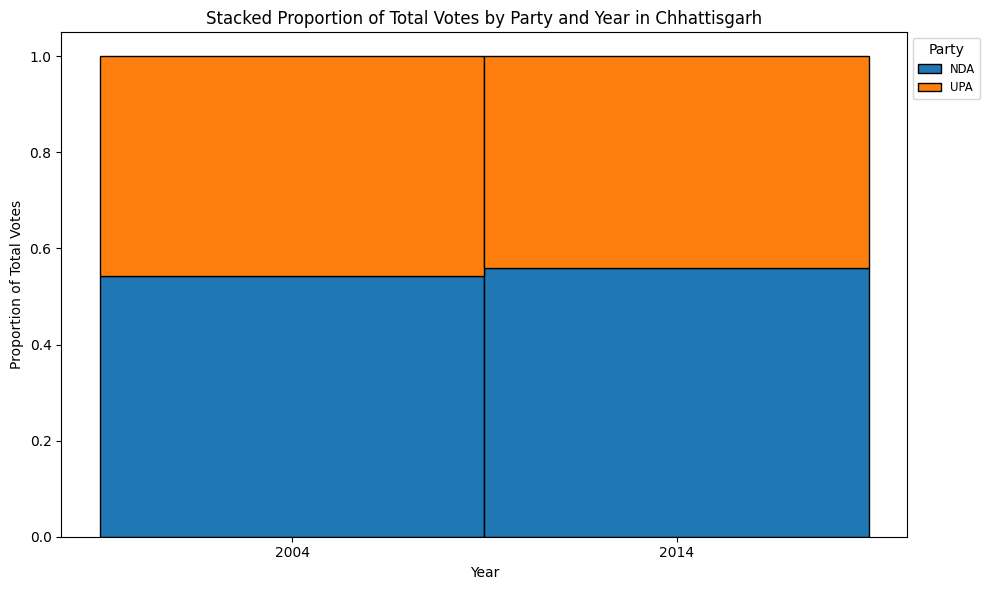

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


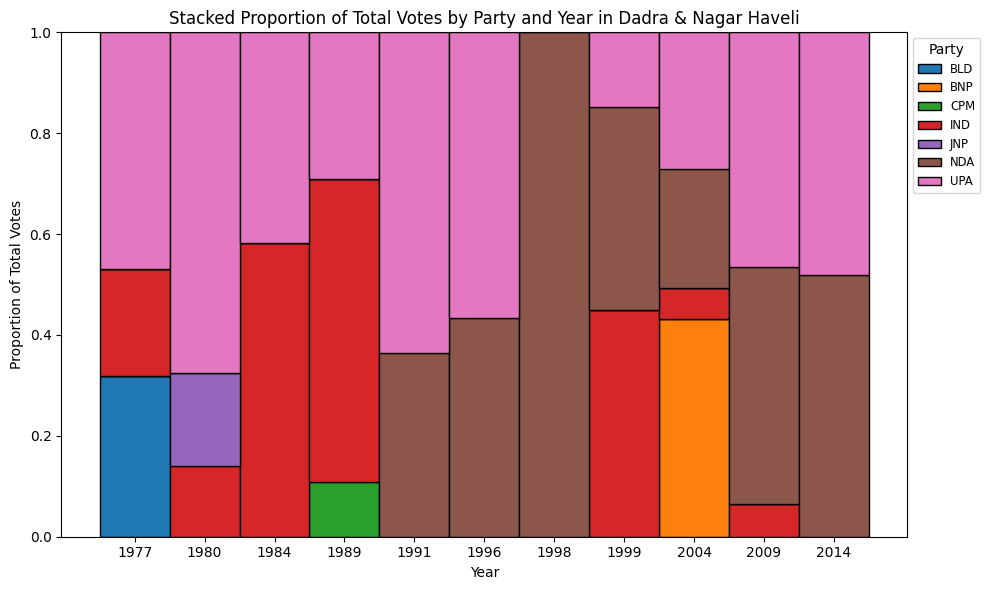

{0: '1989', 1: '1991', 2: '1996', 3: '1998', 4: '1999', 5: '2004', 6: '2009', 7: '2014'}


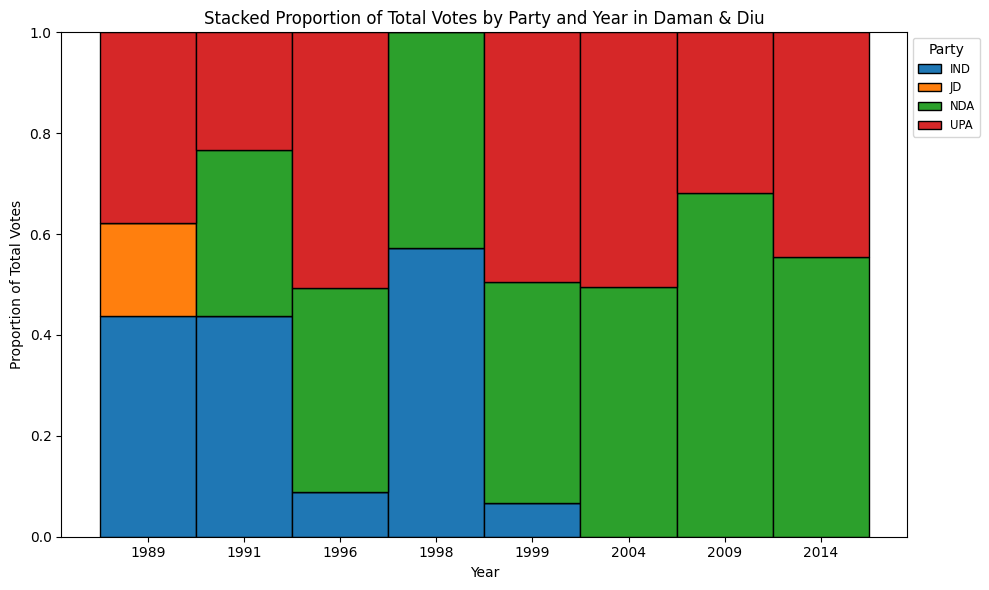

{0: '1984'}


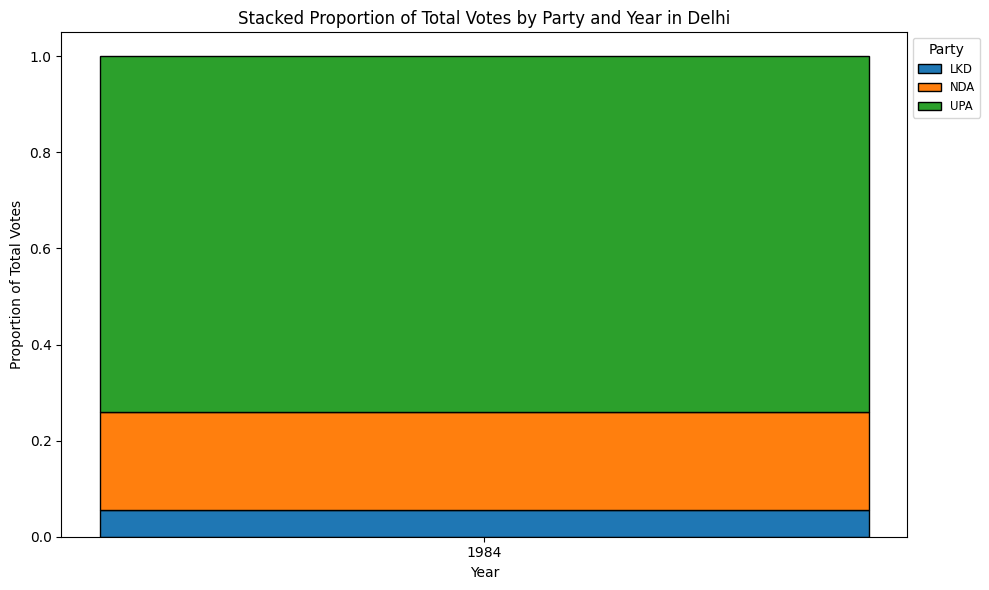

{0: '1989', 1: '1991', 2: '1996', 3: '1998', 4: '1999', 5: '2004', 6: '2009', 7: '2014'}


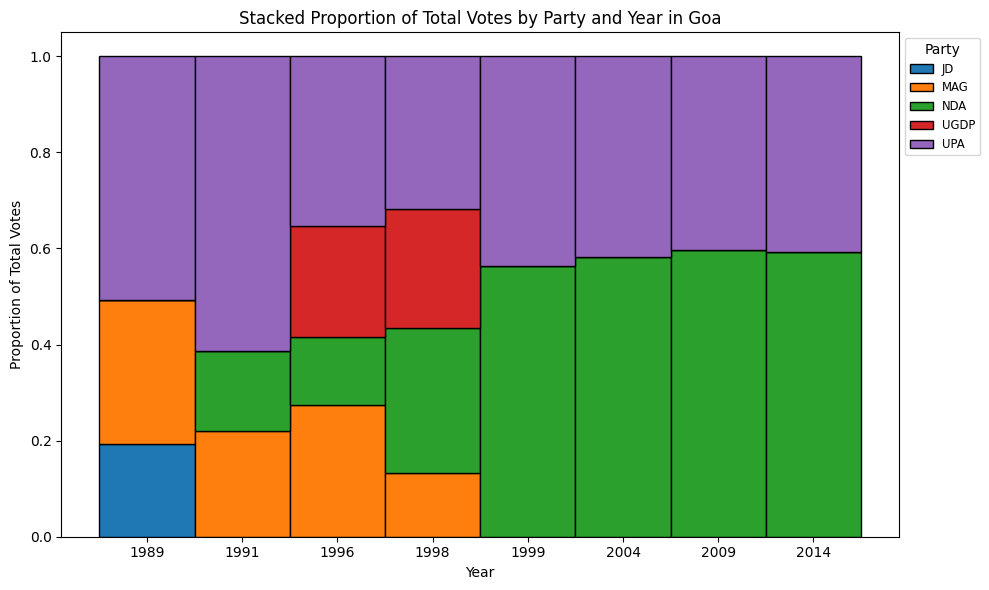

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


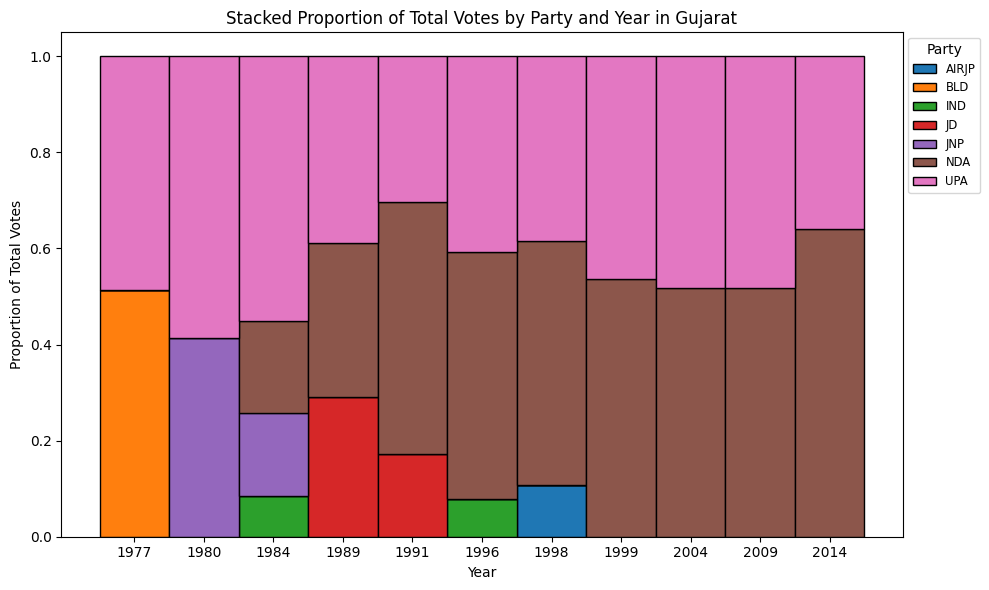

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


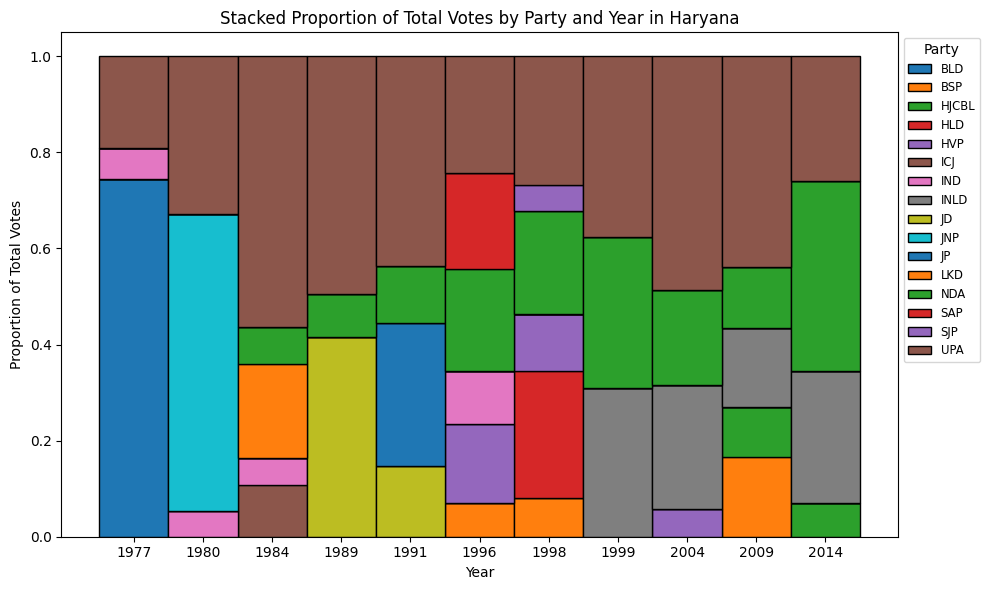

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


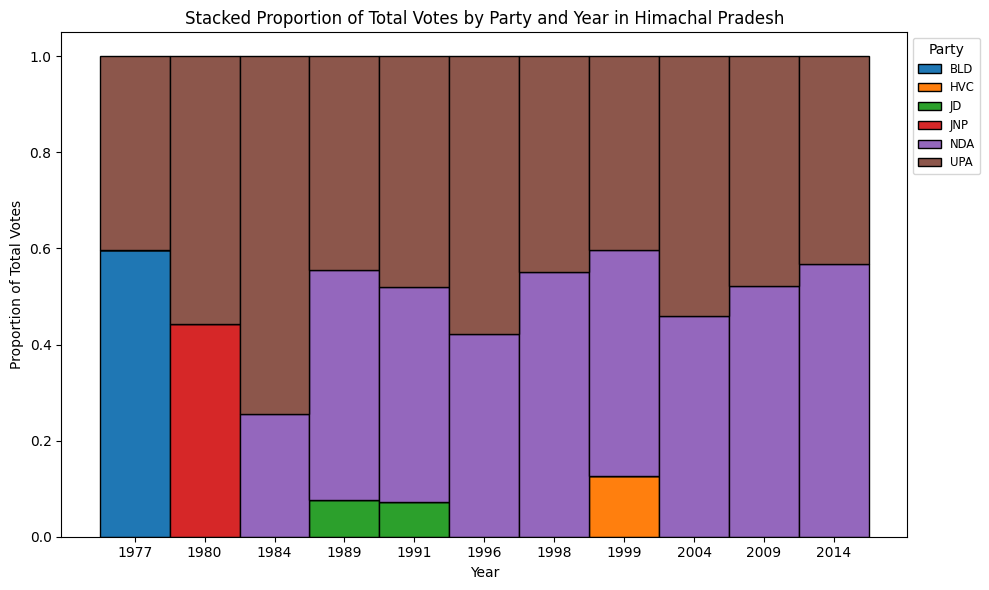

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1996', 5: '1998', 6: '1999', 7: '2004', 8: '2009', 9: '2014'}


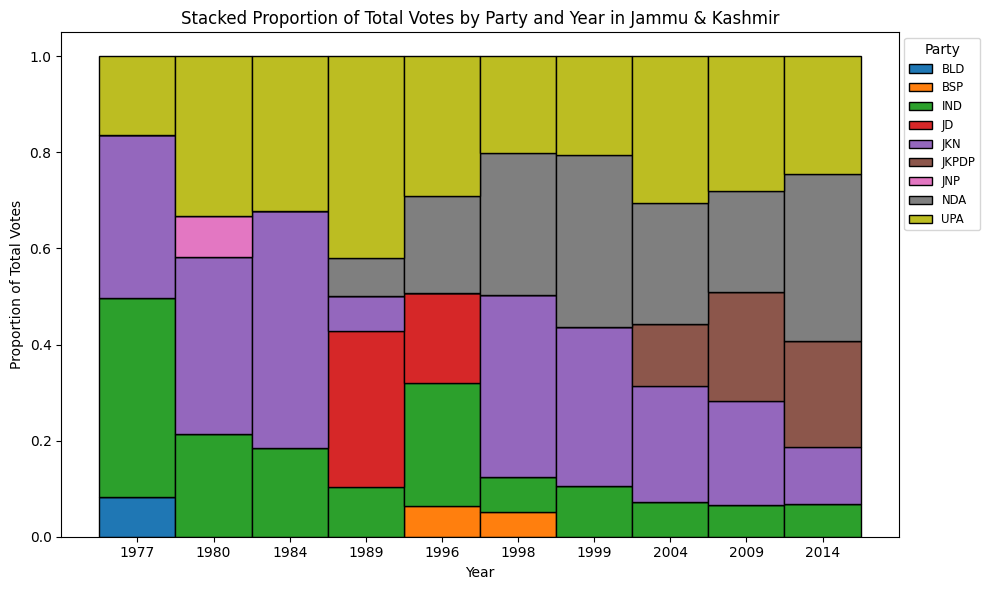

{0: '2004', 1: '2009', 2: '2014'}


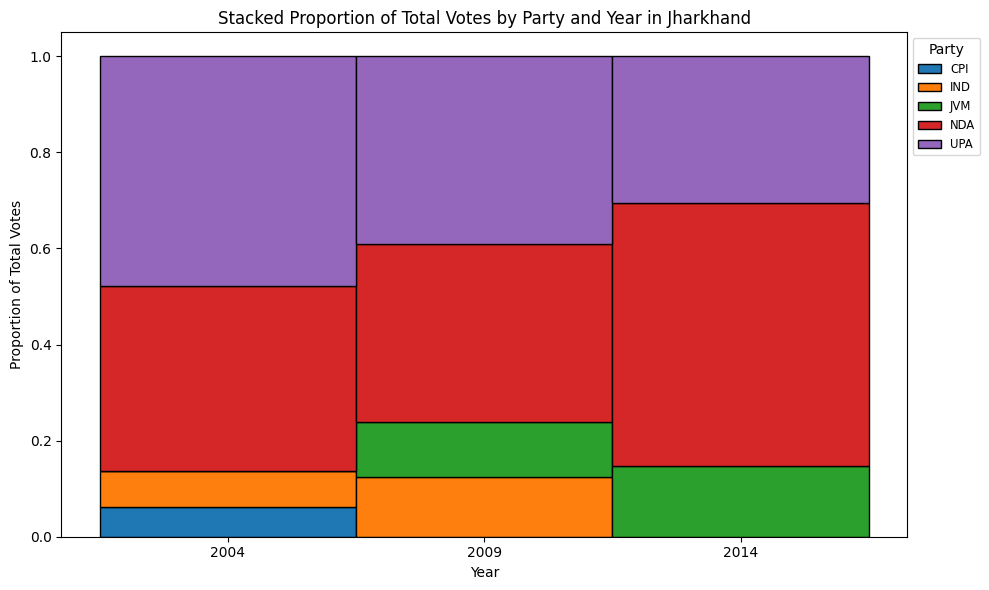

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


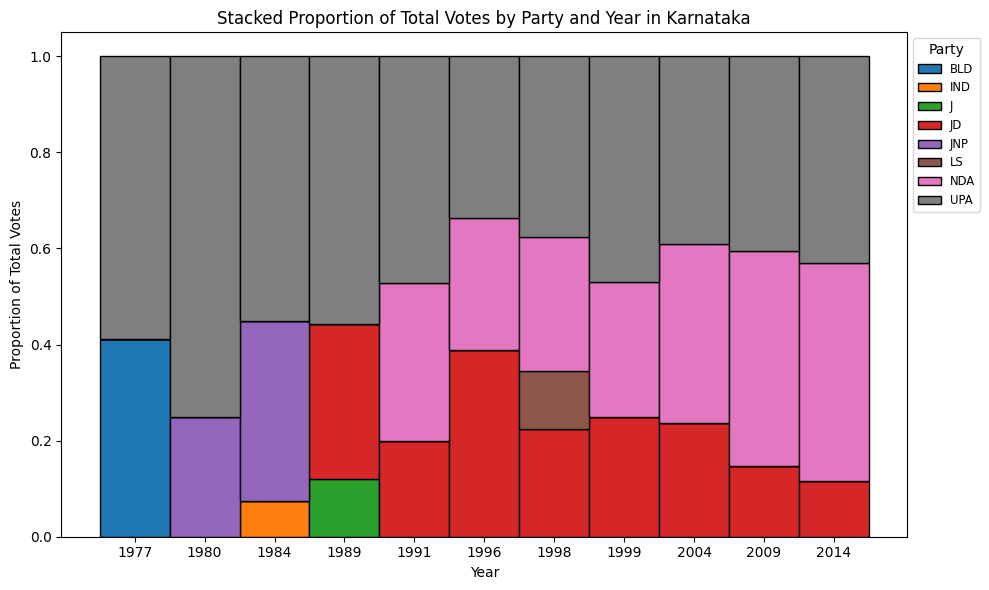

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


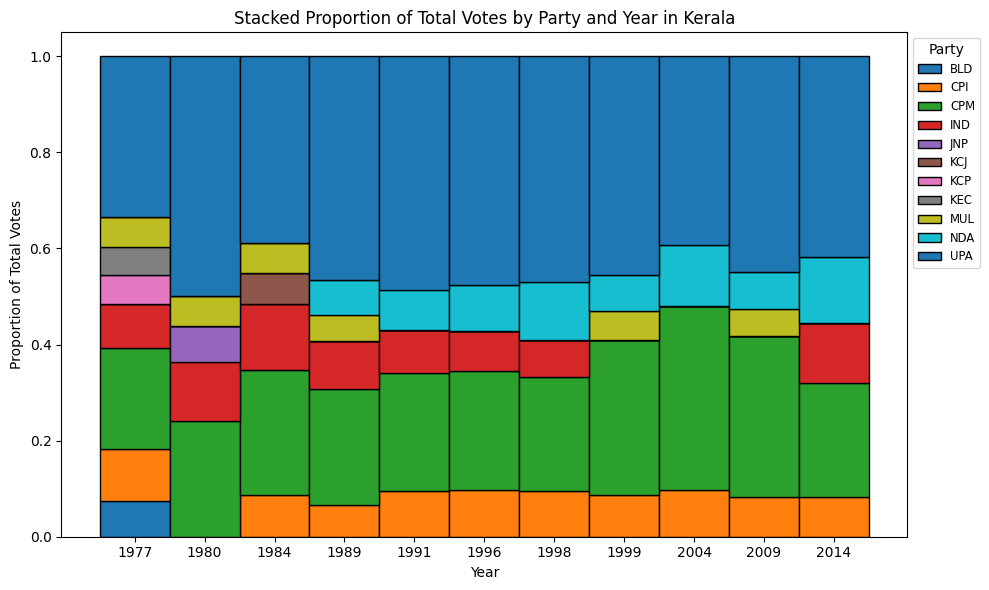

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


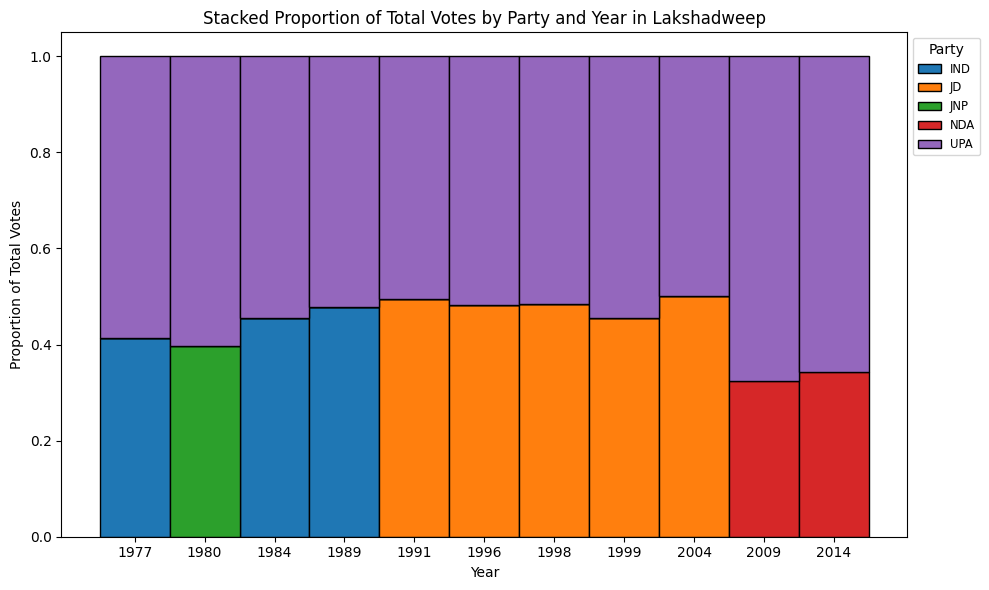

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


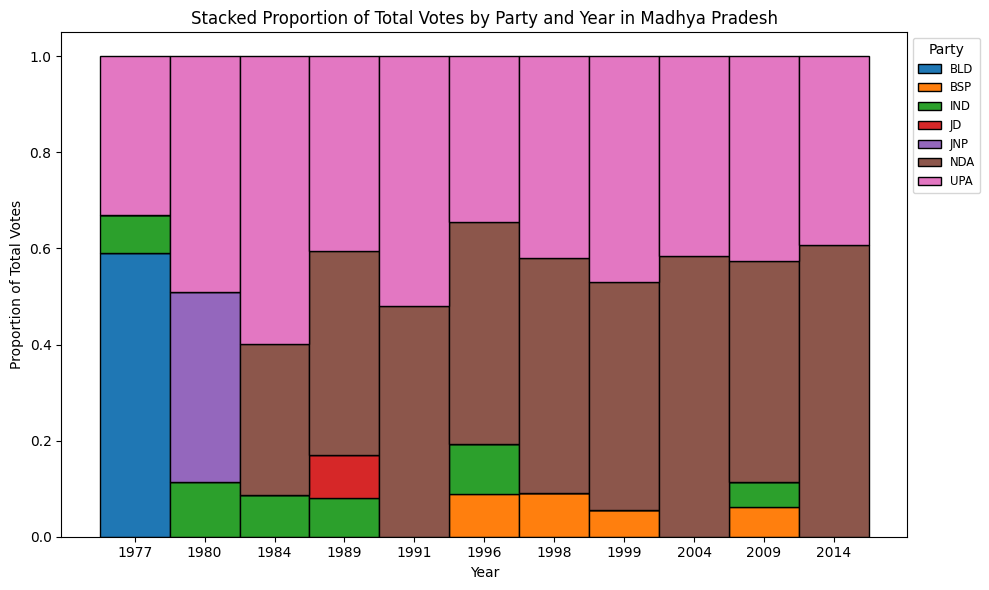

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


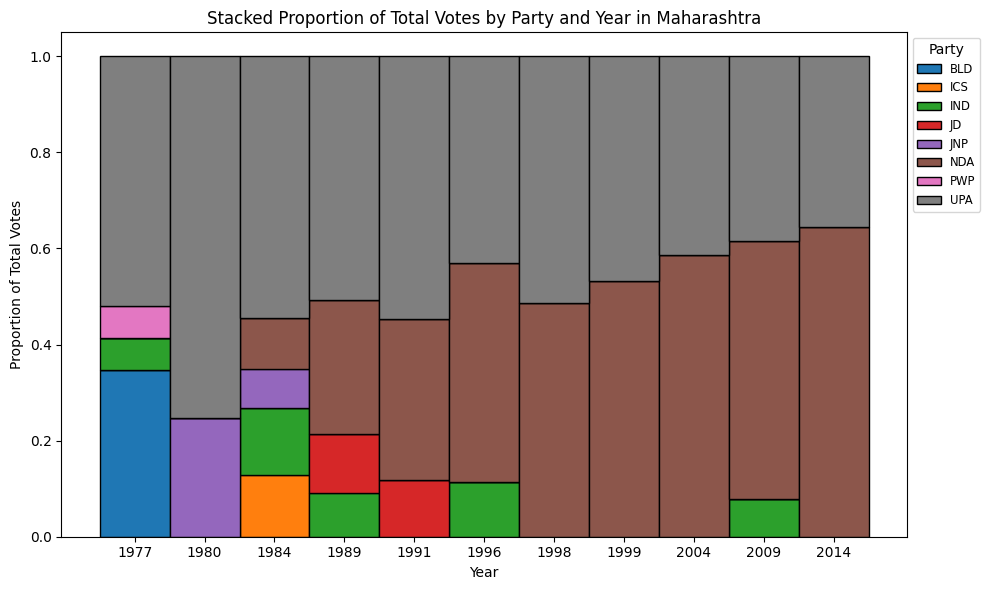

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


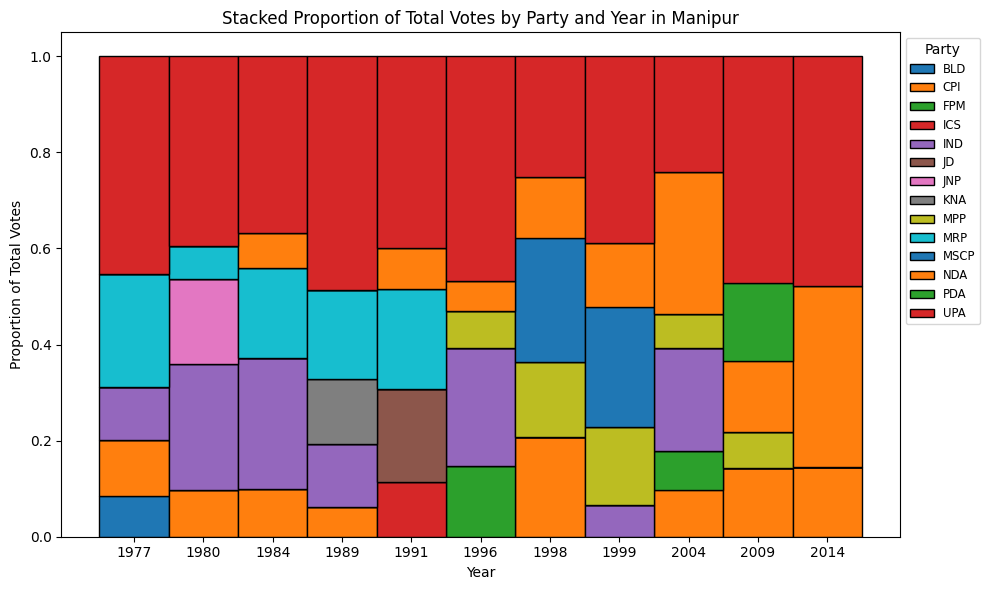

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


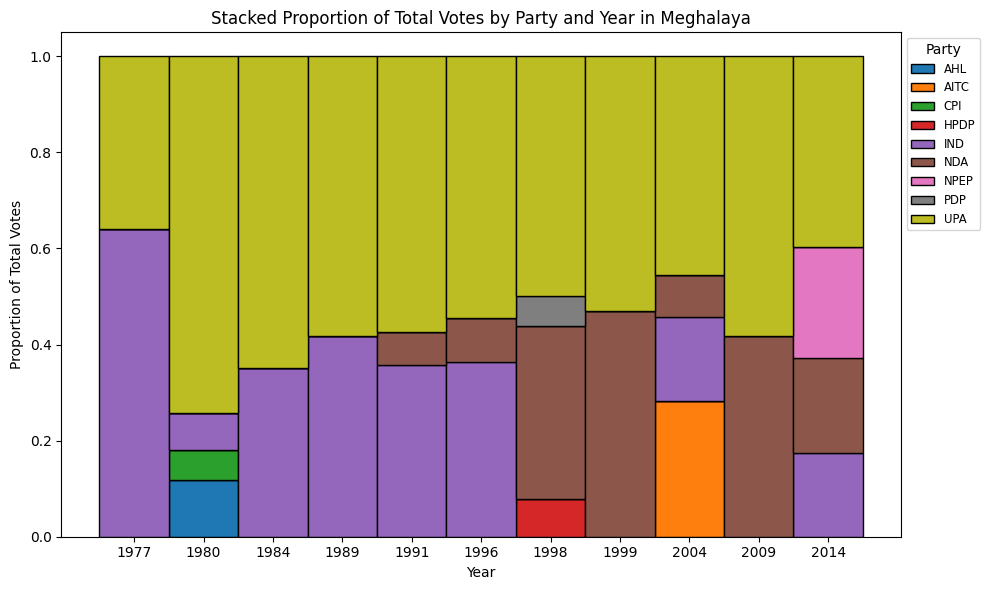

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


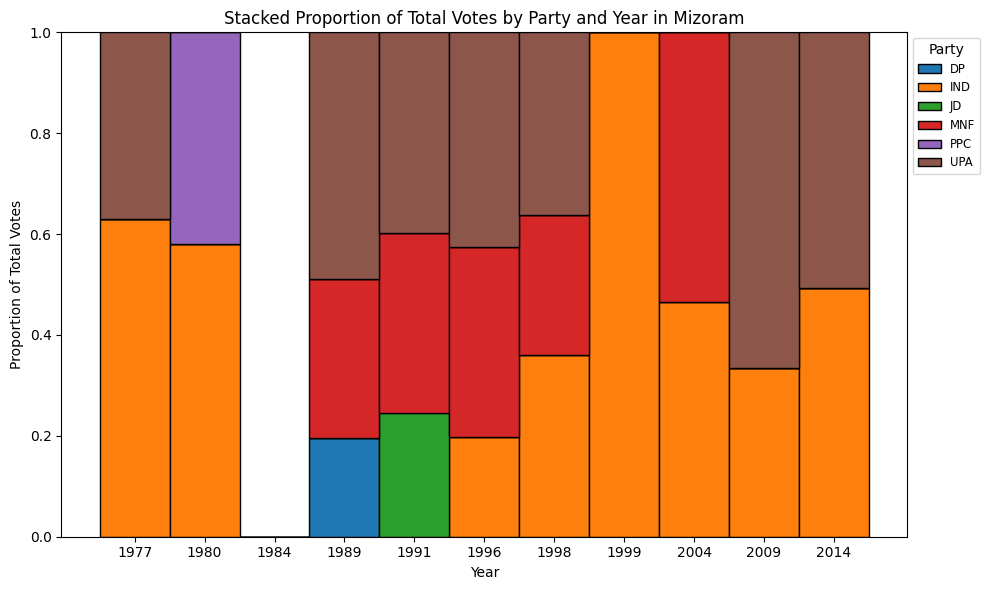

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


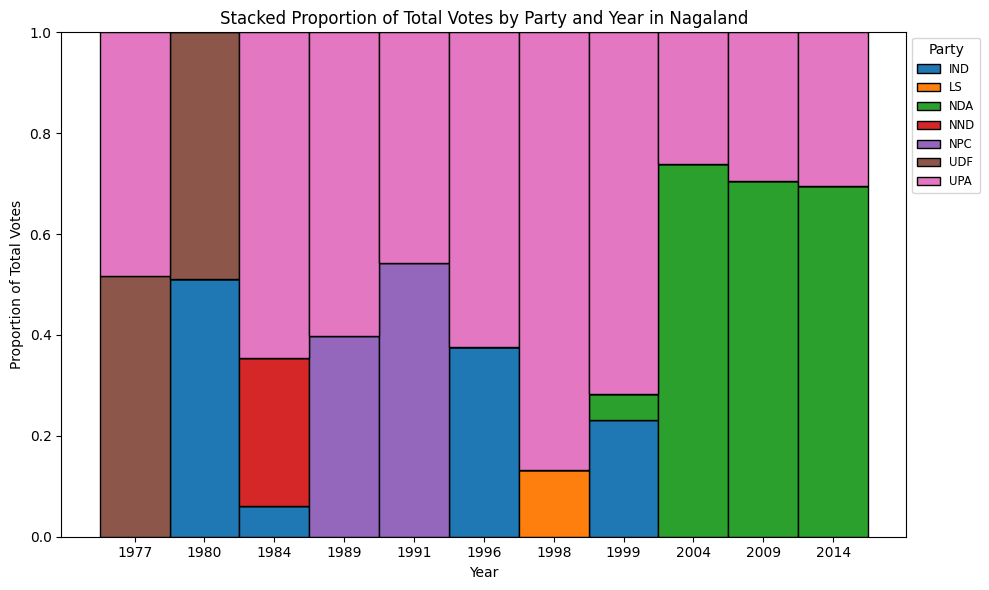

{0: '1977', 1: '1980', 2: '1989', 3: '1991', 4: '1996', 5: '1998', 6: '1999', 7: '2004'}


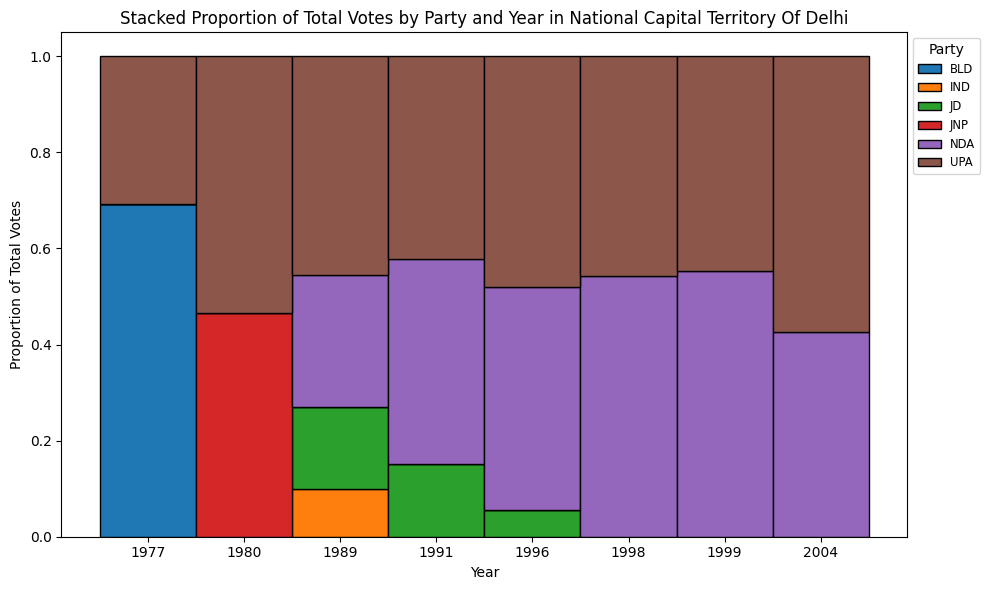

{0: '2009', 1: '2014'}


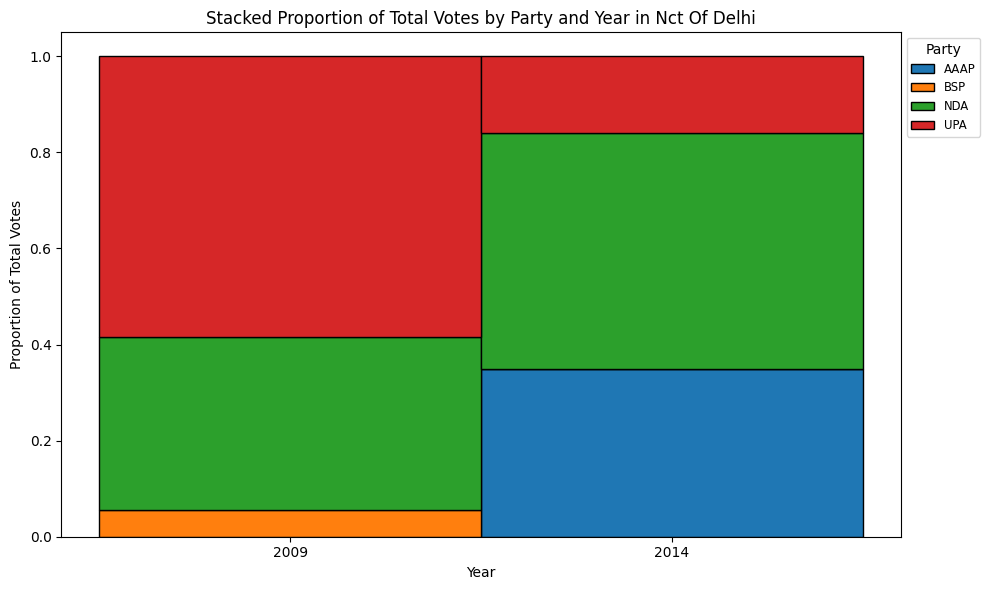

{0: '2014'}


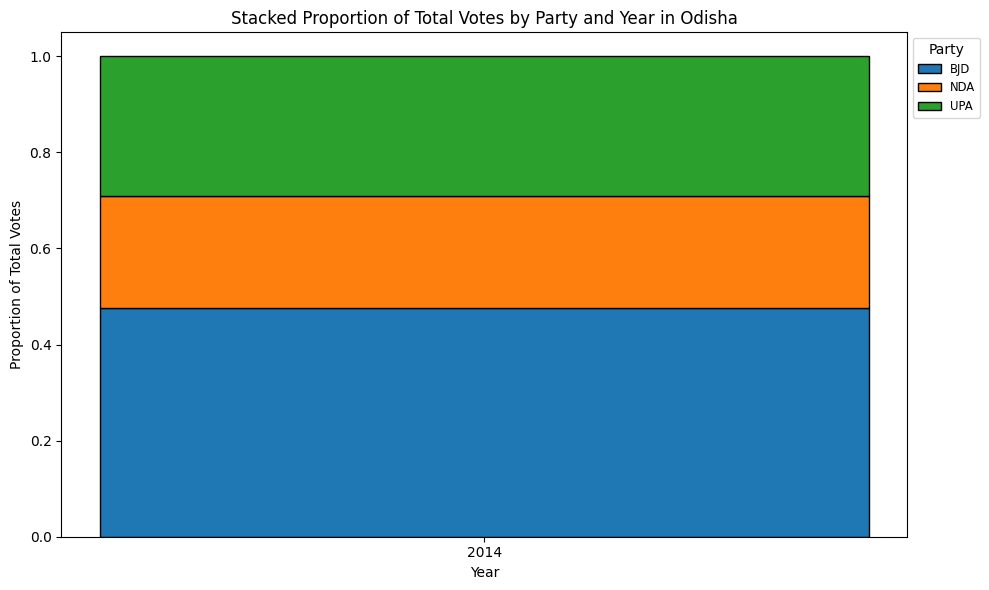

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009'}


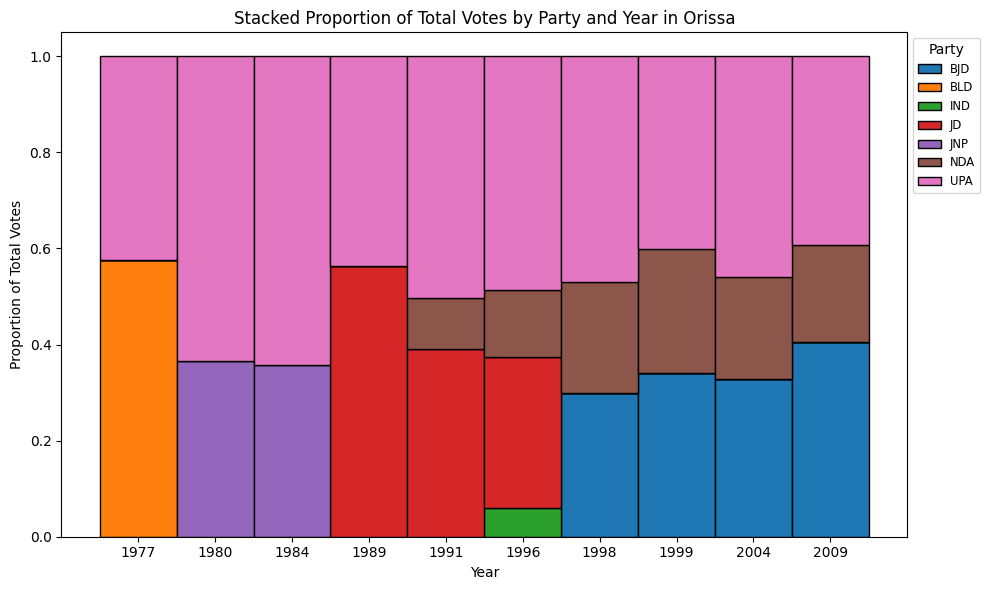

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004'}


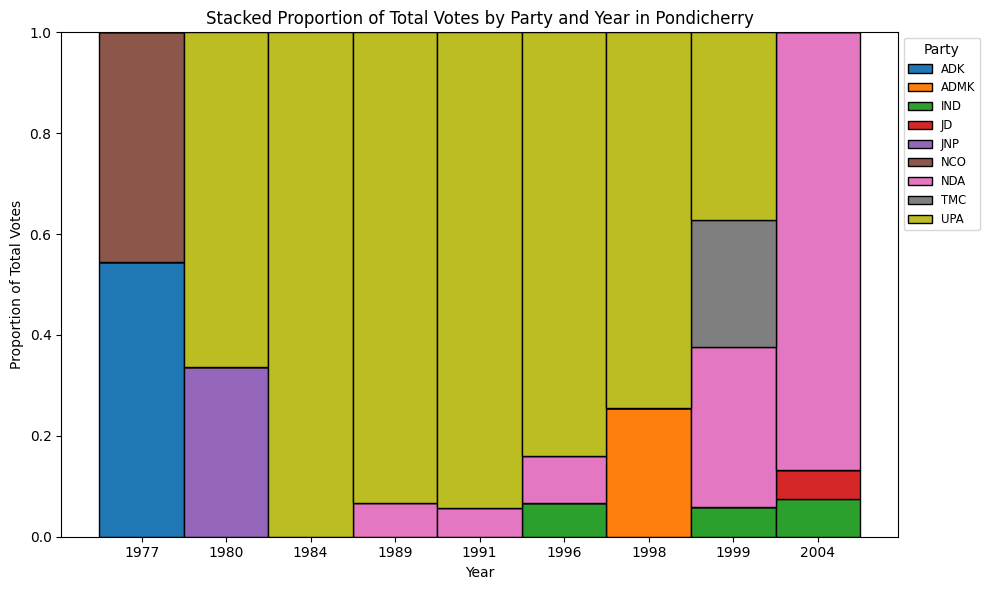

{0: '2009', 1: '2014'}


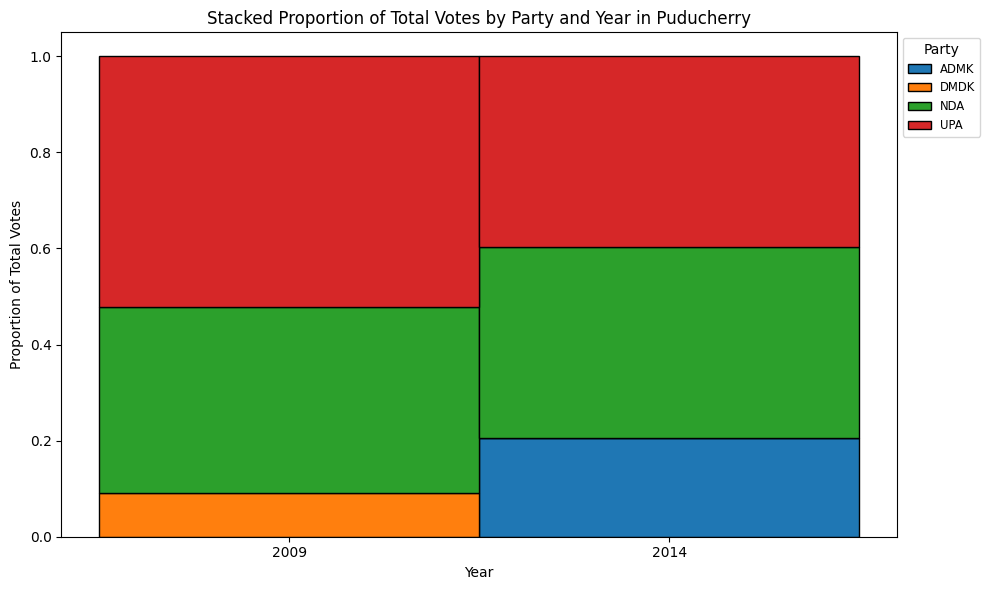

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


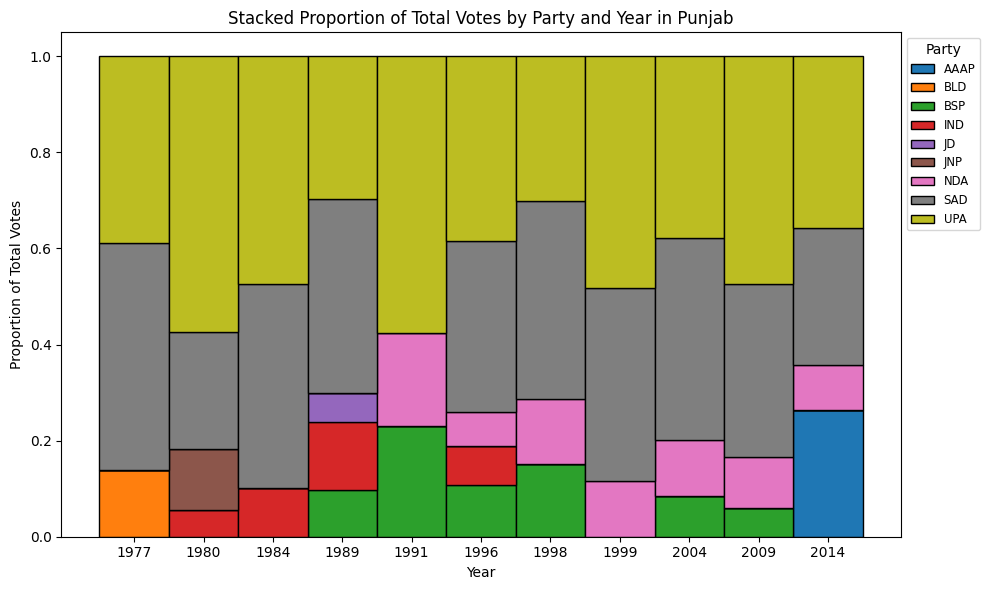

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


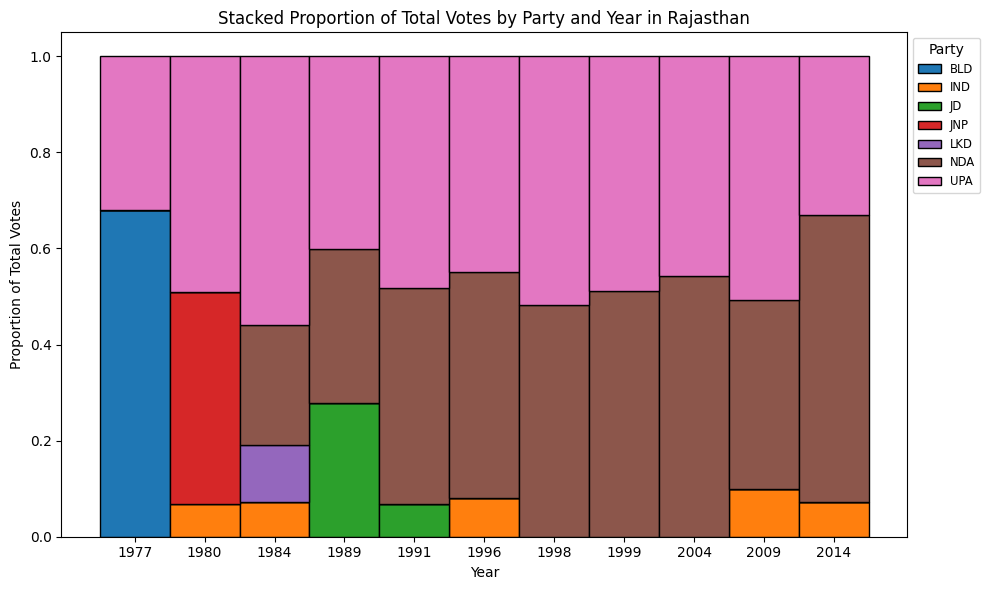

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


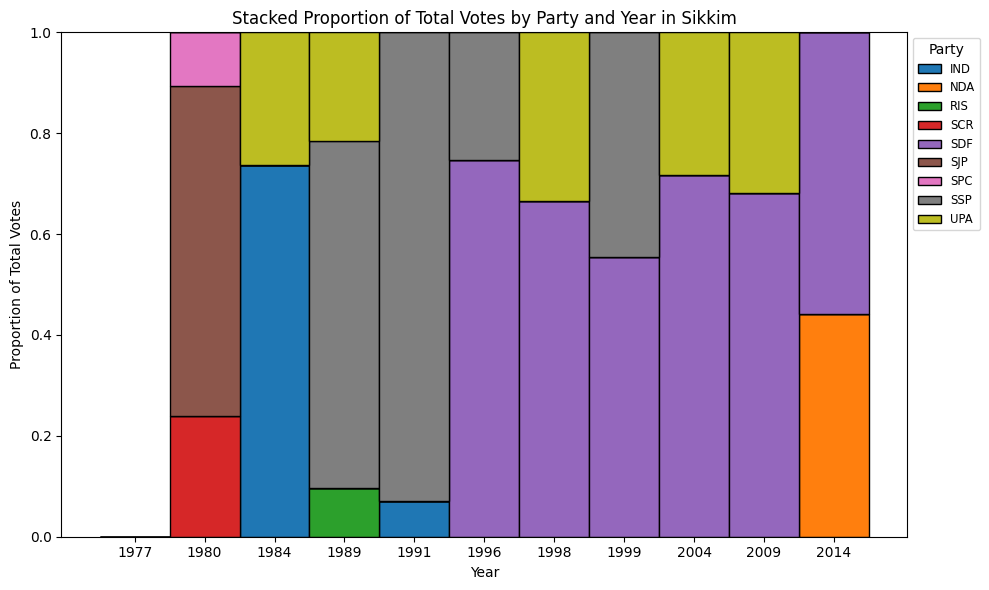

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


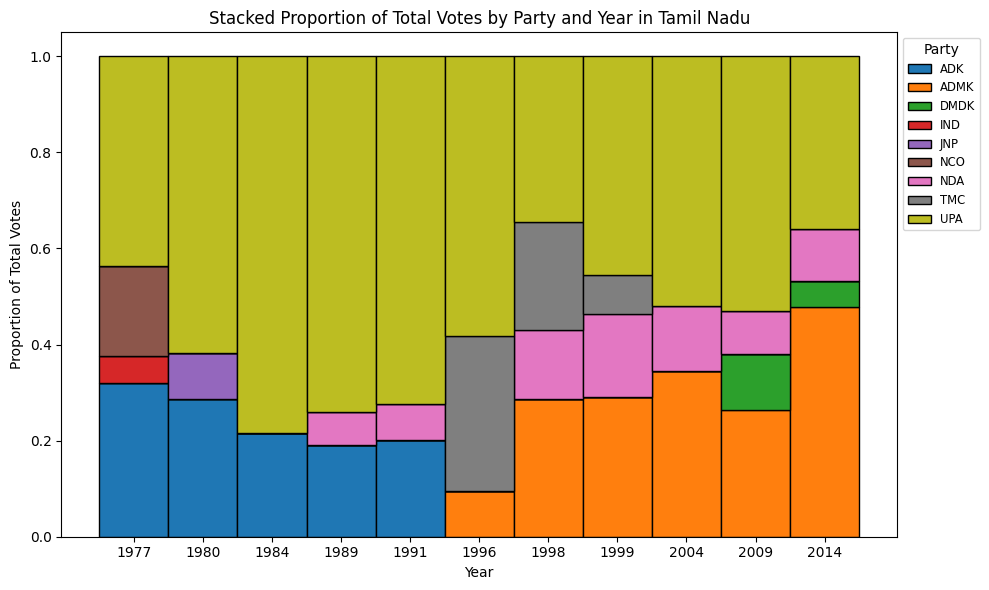

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


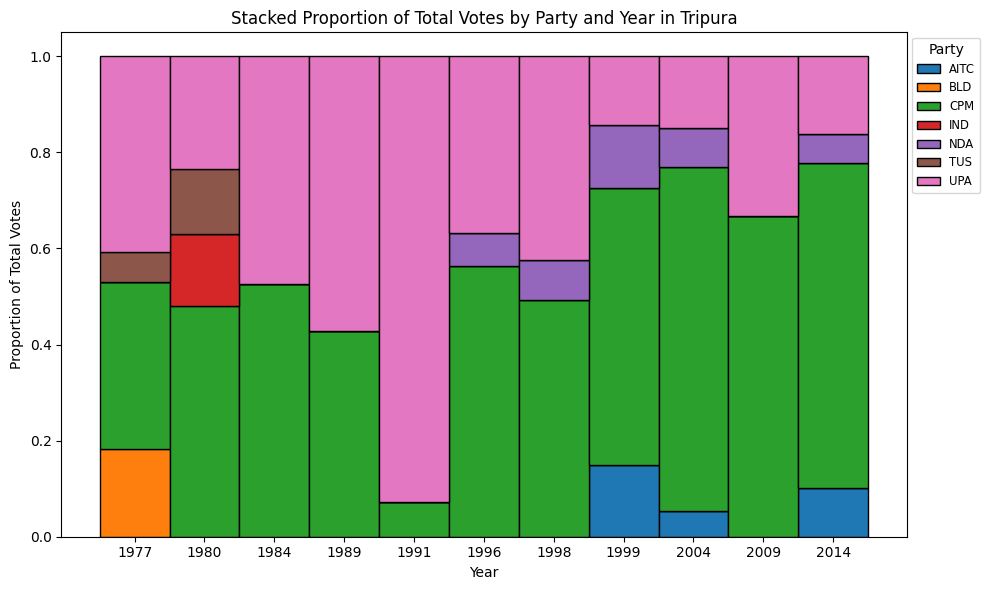

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


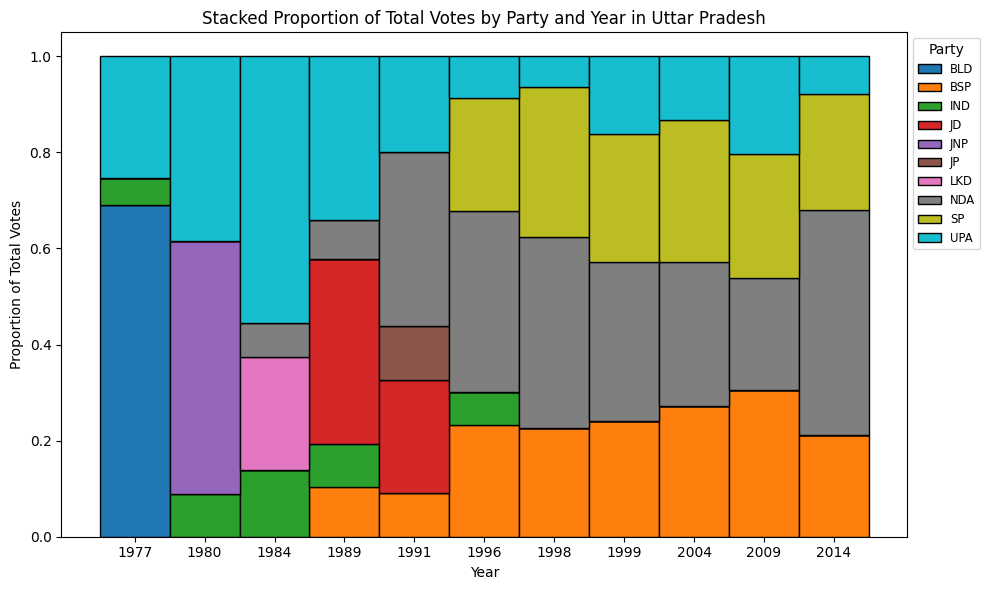

{0: '2009', 1: '2014'}


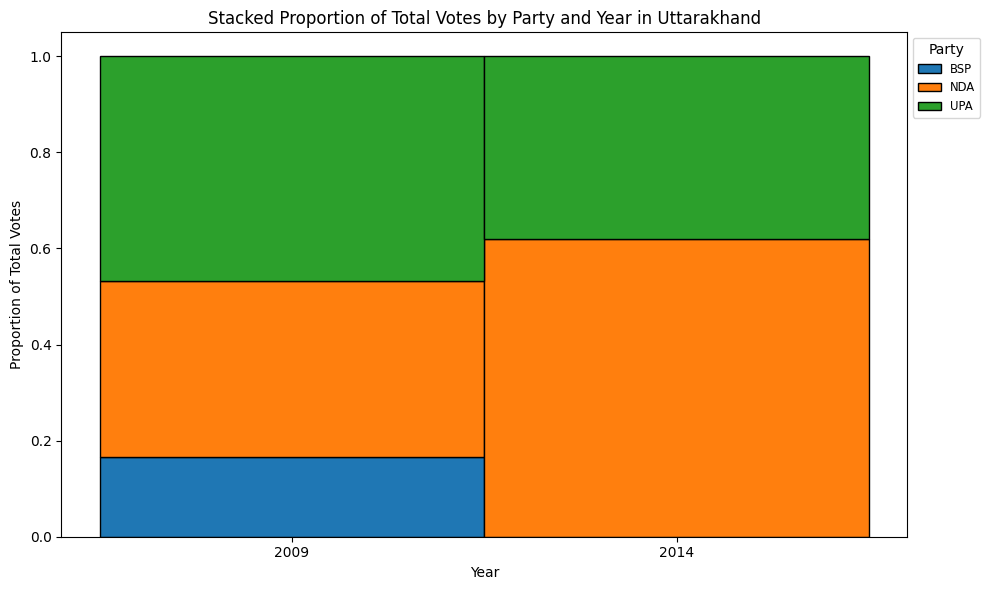

{0: '2004'}


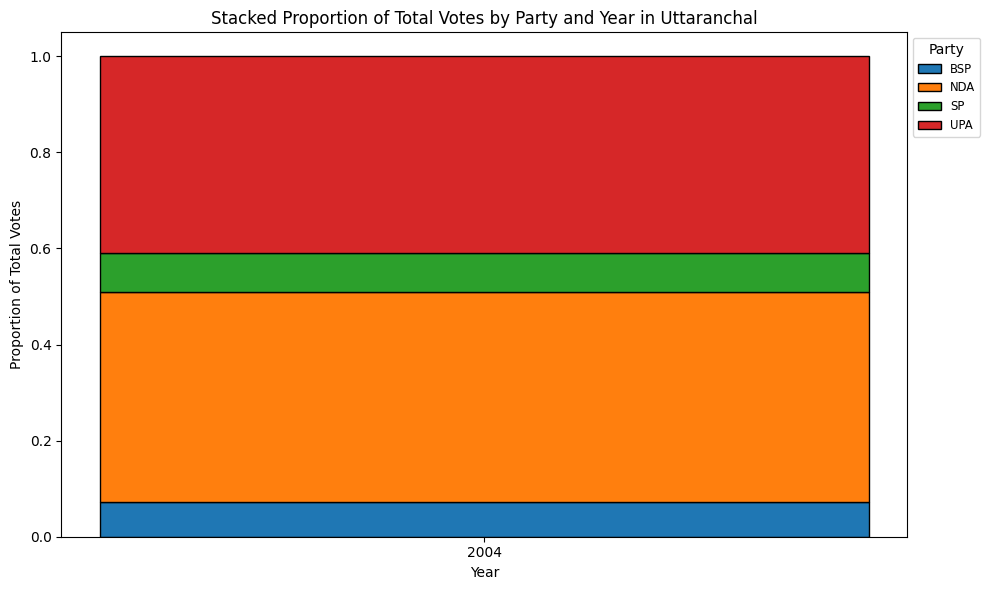

{0: '1977', 1: '1980', 2: '1984', 3: '1989', 4: '1991', 5: '1996', 6: '1998', 7: '1999', 8: '2004', 9: '2009', 10: '2014'}


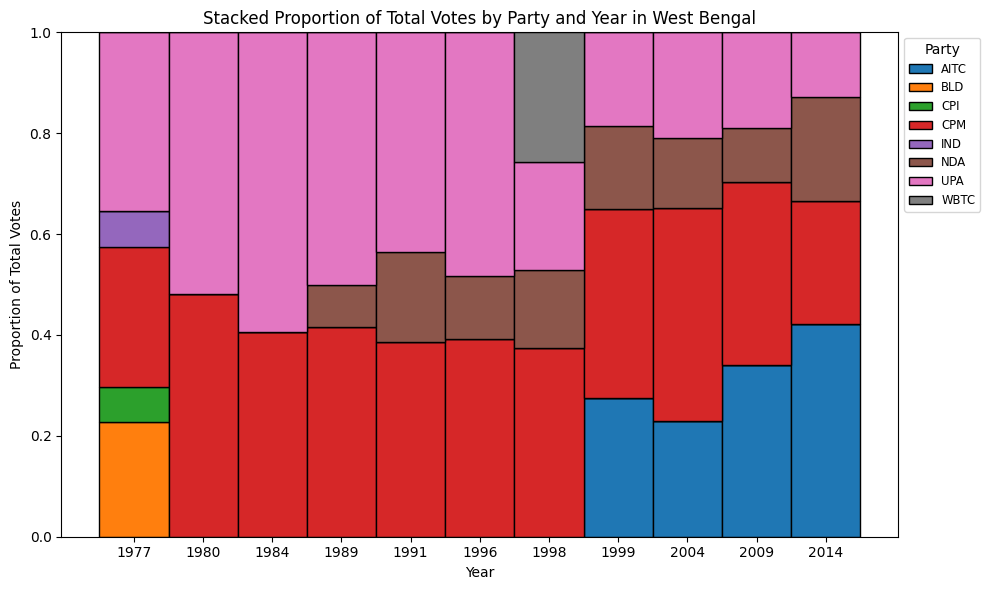

In [8]:
import matplotlib.pyplot as plt

def plot_stacked_party_ratios_by_state(aggregated_data, state):

    years = sorted(aggregated_data[state].keys())

    # Dynamically determine the parties present in the state data
    parties = set()
    for year in years:
        parties.update(aggregated_data[state][year].keys())
    parties_order = sorted(parties)
    #parties_order = ['UPA', 'BJP', 'IND']

    # Initialize a dict to hold the ratios for each party
    ratios_per_party = {party: [] for party in parties_order}

    # Populate the ratios for each party and each year
    for year in years:
        year_total = sum(votes for _, votes in aggregated_data[state][year].values())
        for party in parties_order:
            # Get the party data for the year, default to (0, 0) if not found
            party_data = aggregated_data[state][year].get(party, (0, 0))

            # Calculate the ratio if year_total is not zero
            ratio = party_data[1] / year_total if year_total else 0
            ratios_per_party[party].append(ratio)

    # Create the stacked bar plot for each state
    fig, ax = plt.subplots(figsize=(10, 6))
    bottom = [0] * len(years)
    
    years_axis = {i:str(y) for i, y in enumerate(list(years))}
    print(years_axis)
    for party in parties_order:
        ax.bar(years_axis.keys(), ratios_per_party[party], bottom=bottom, label=party, width=1, edgecolor='black')
        bottom = [bottom[i] + ratios_per_party[party][i] for i in range(len(years))]

    ax.set_xlabel('Year')
    ax.set_ylabel('Proportion of Total Votes')
    ax.set_title(f'Stacked Proportion of Total Votes by Party and Year in {state}')
    ax.legend(title='Party', loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    ax.set_xticks(list(years_axis.keys()))
    ax.set_xticklabels(list(years_axis.values()))
   
    plt.tight_layout()
    # plt.grid(True)
    # ax.set_axisbelow(True)
    plt.show()
    
     

state_list = ['Andaman & Nicobar Islands', 'Andhra Pradesh', 'Arunachal Pradesh',
       'Assam', 'Bihar', 'Chandigarh', 'Chattisgarh', 'Chhattisgarh',
       'Dadra & Nagar Haveli', 'Daman & Diu', 'Delhi', 'Goa', 
       'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu & Kashmir', 'Jharkhand', 
       'Karnataka', 'Kerala', 'Lakshadweep', 'Madhya Pradesh', 'Maharashtra',
       'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
       'National Capital Territory Of Delhi', 'Nct Of Delhi', 'Odisha',
       'Orissa', 'Pondicherry', 'Puducherry', 'Punjab', 'Rajasthan',
       'Sikkim', 'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'Uttarakhand',
       'Uttaranchal', 'West Bengal']

for state in state_list:
    plot_stacked_party_ratios_by_state(results, state)




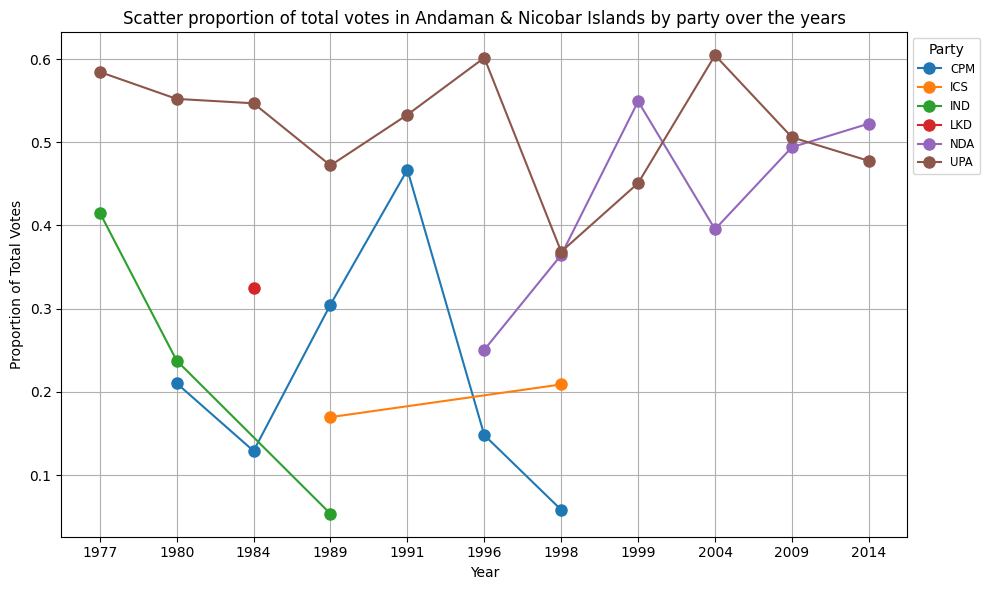

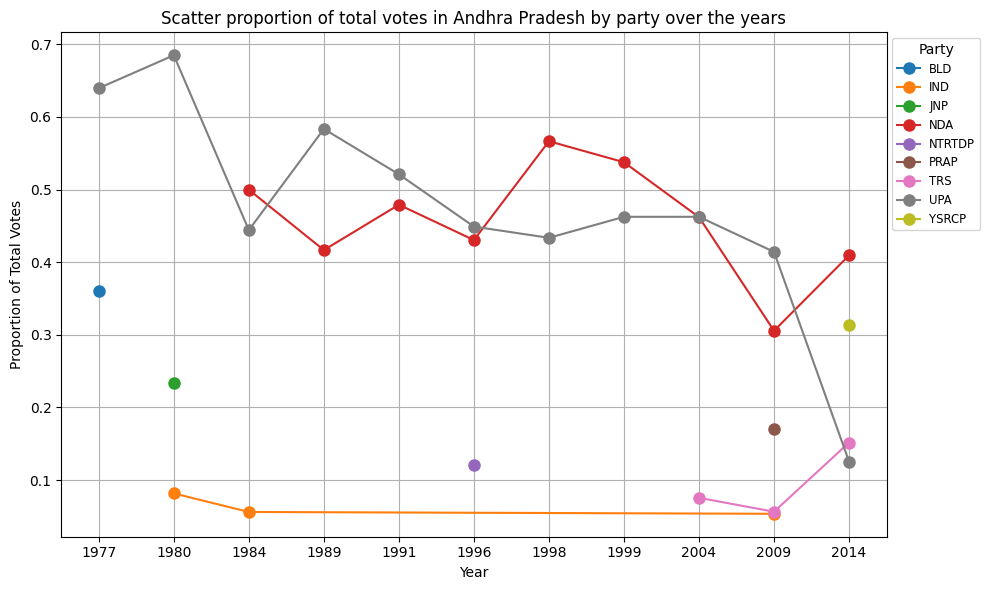

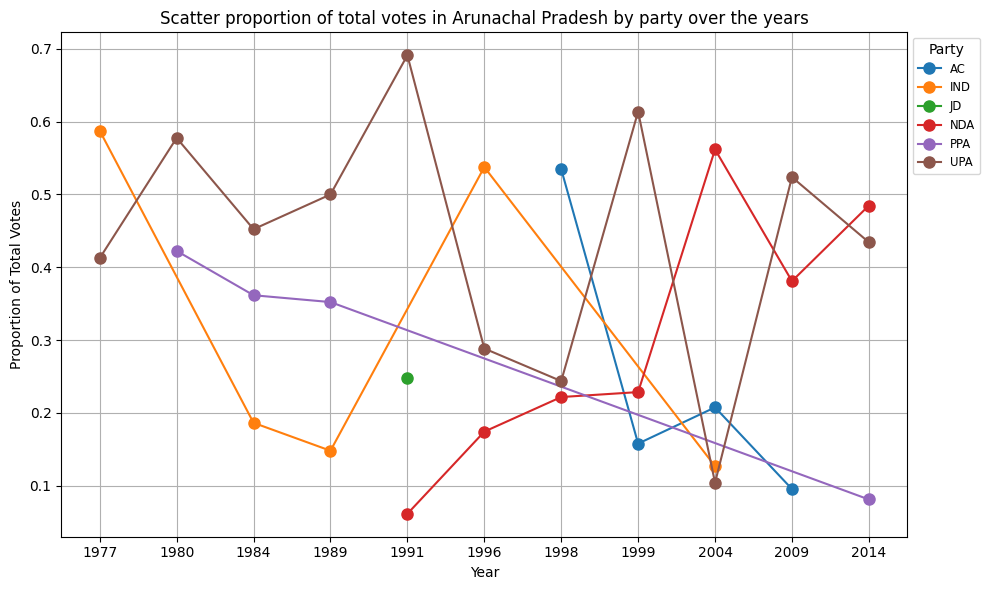

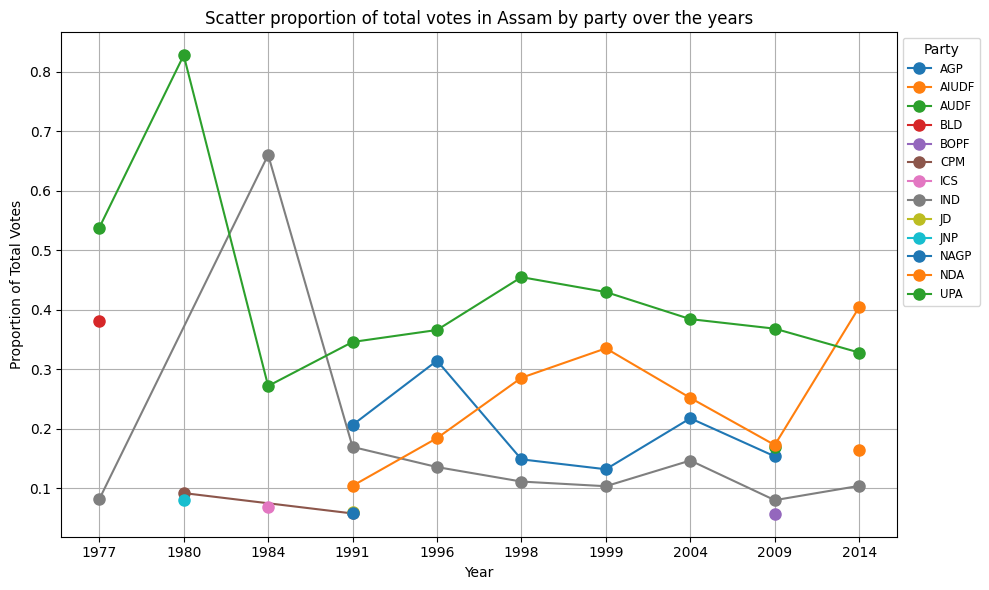

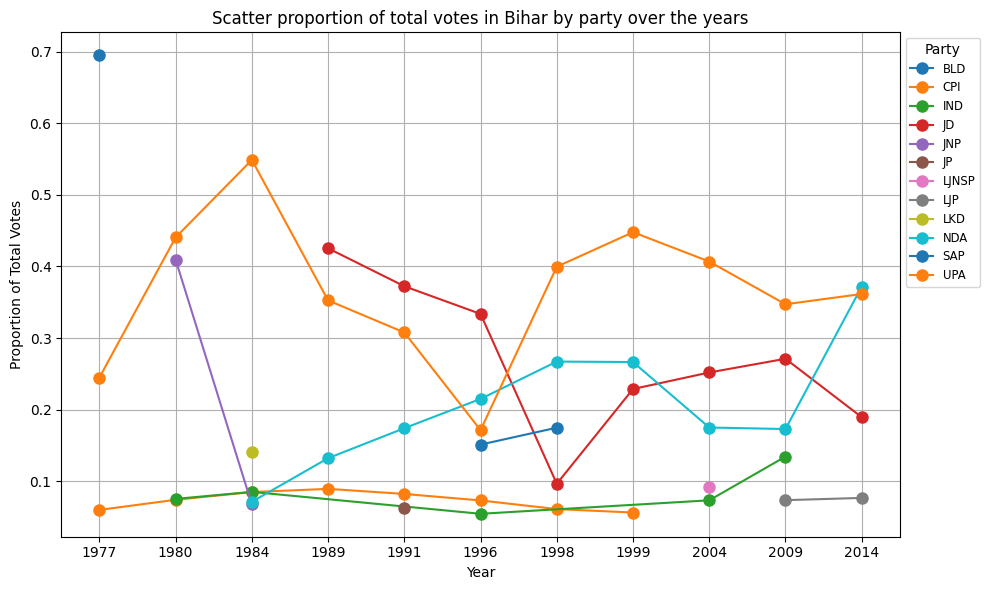

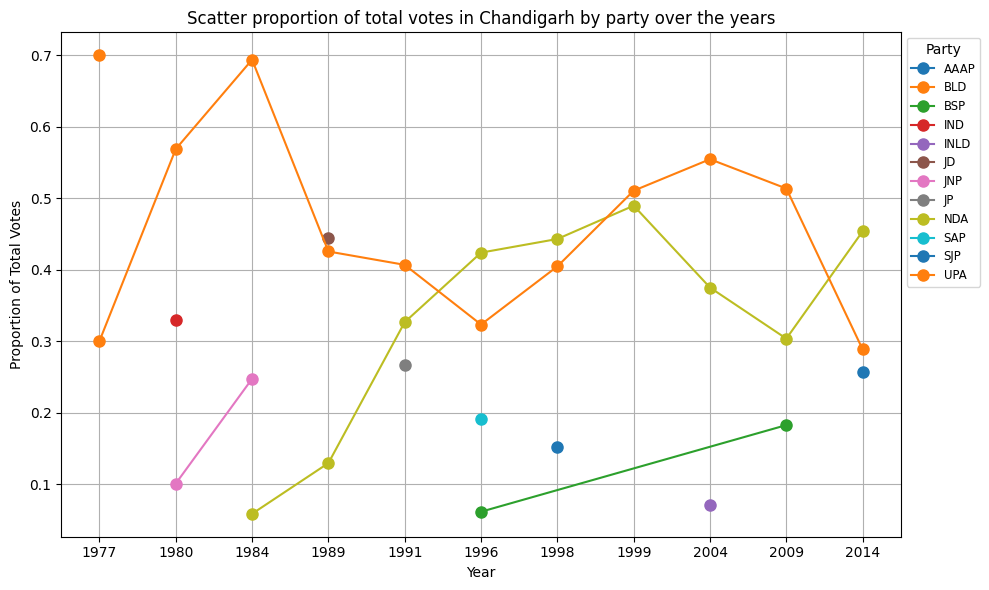

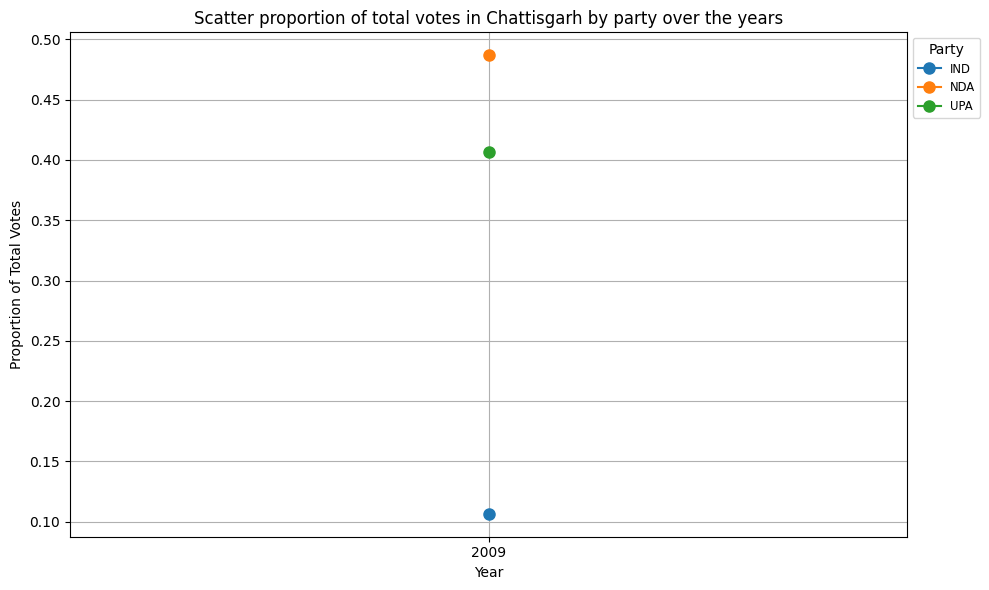

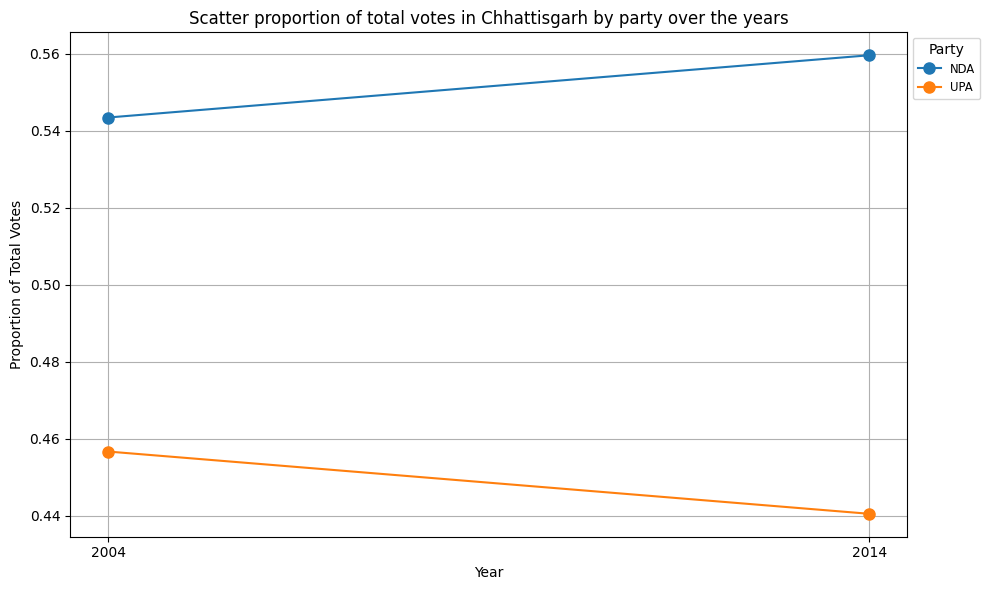

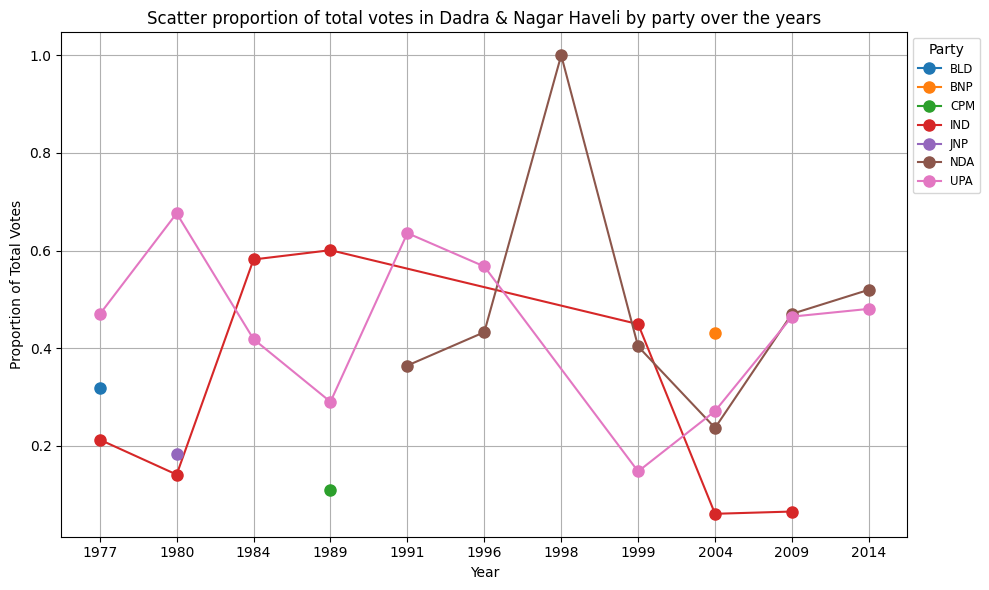

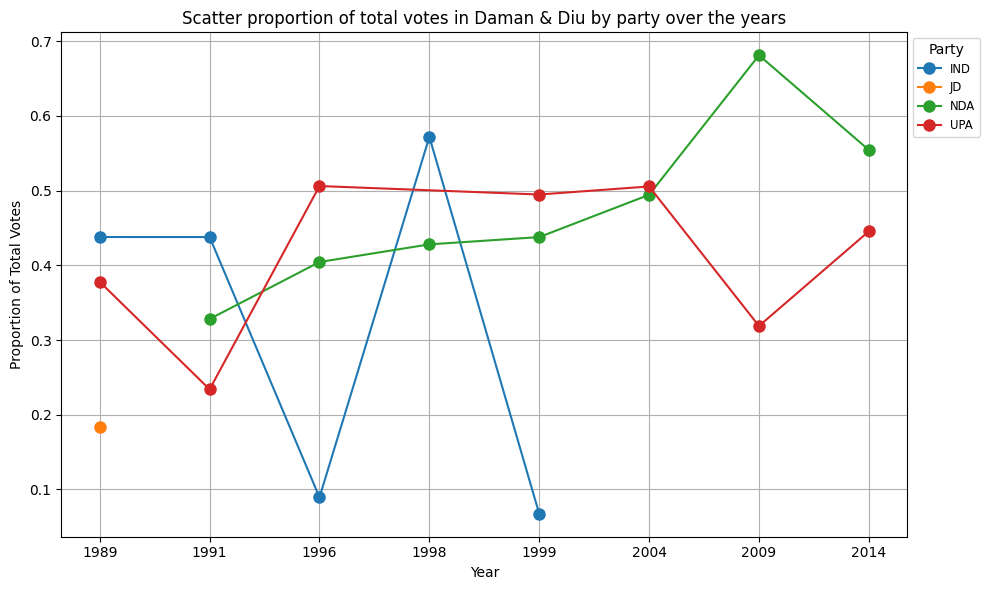

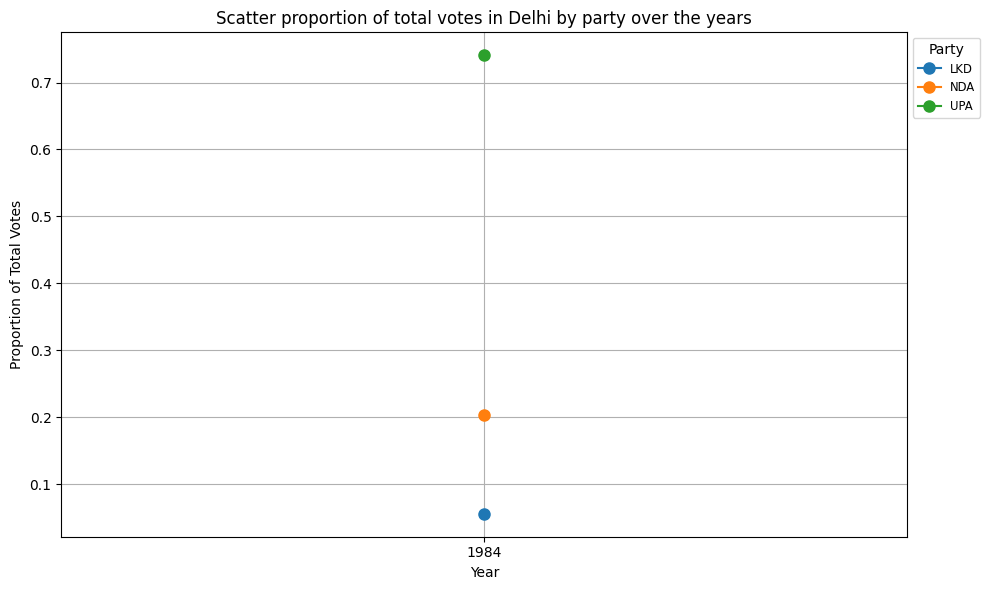

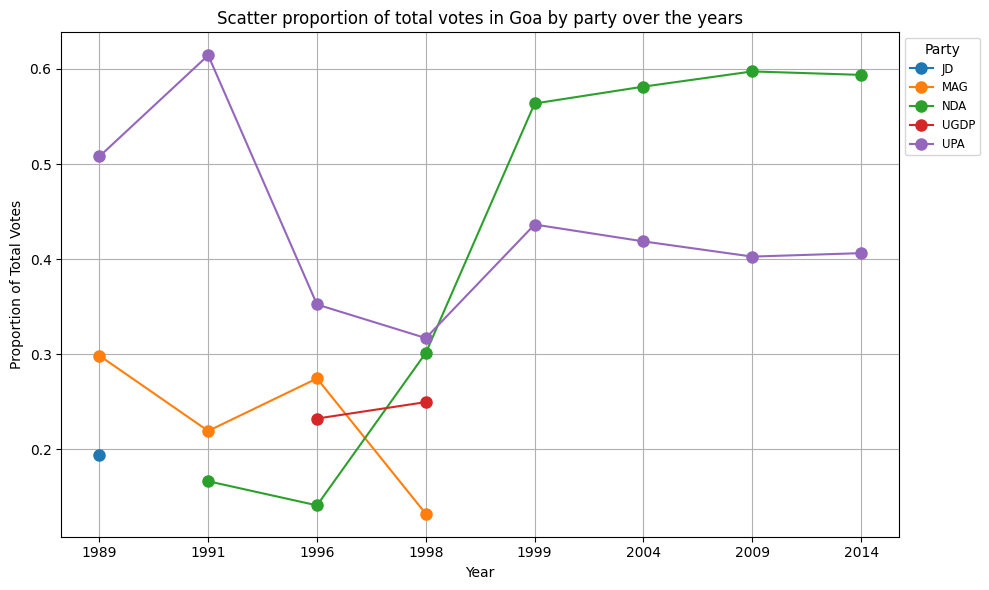

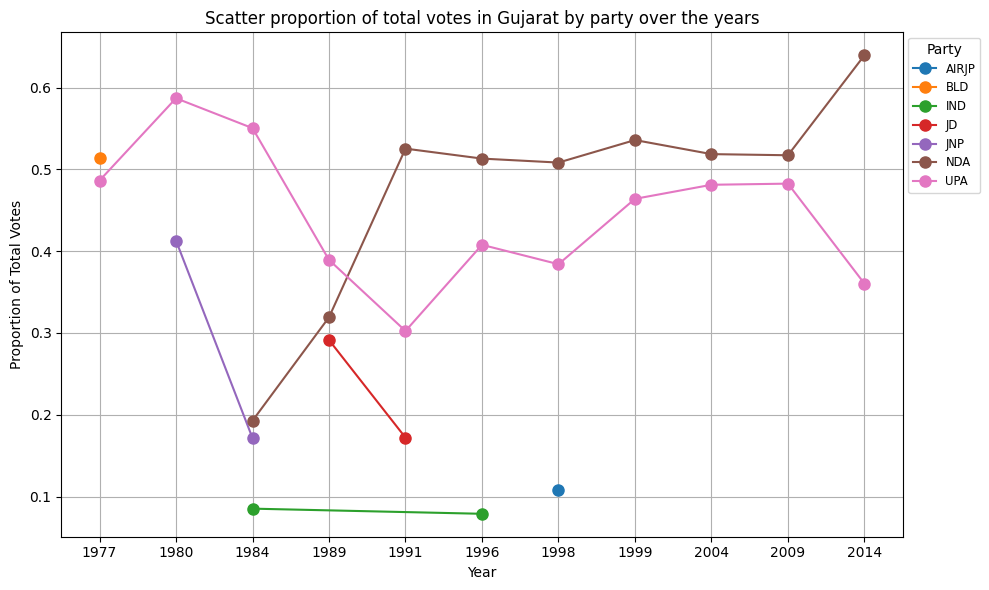

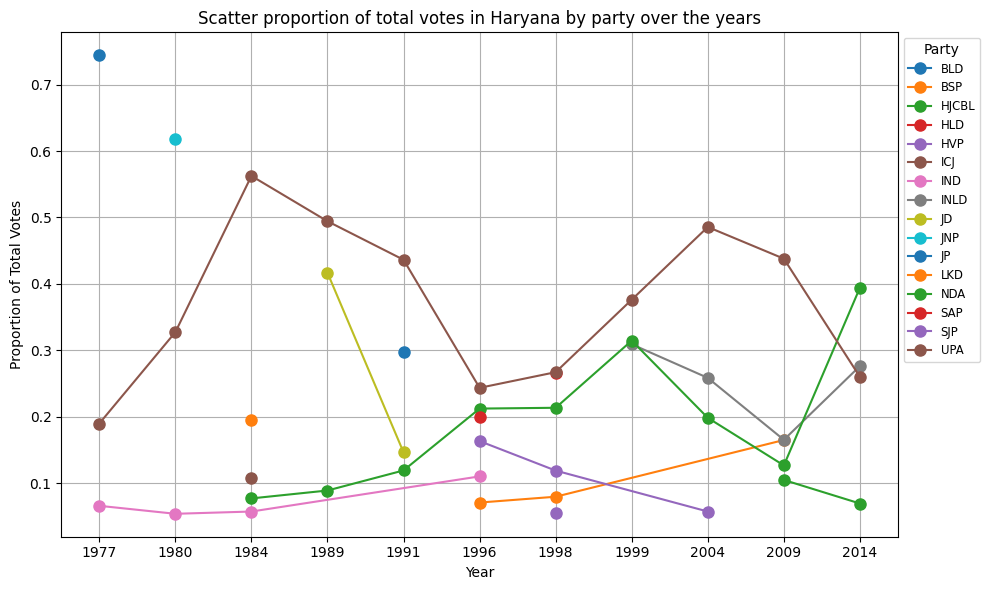

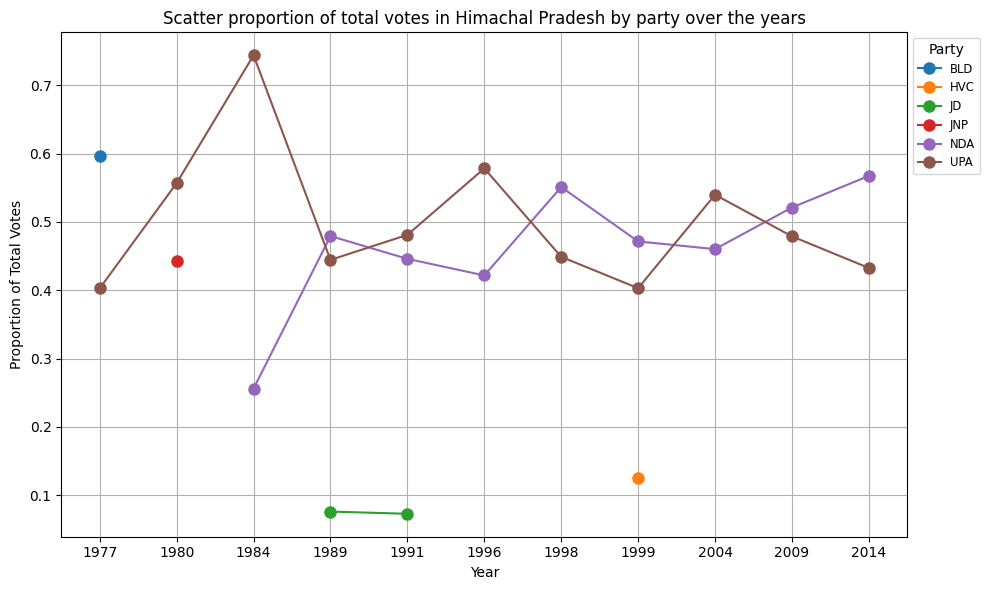

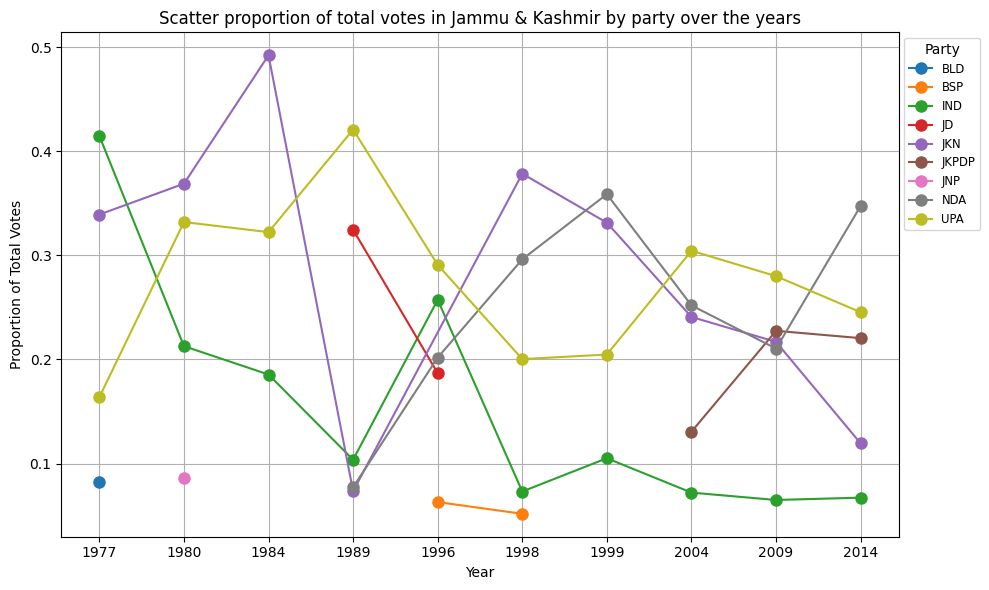

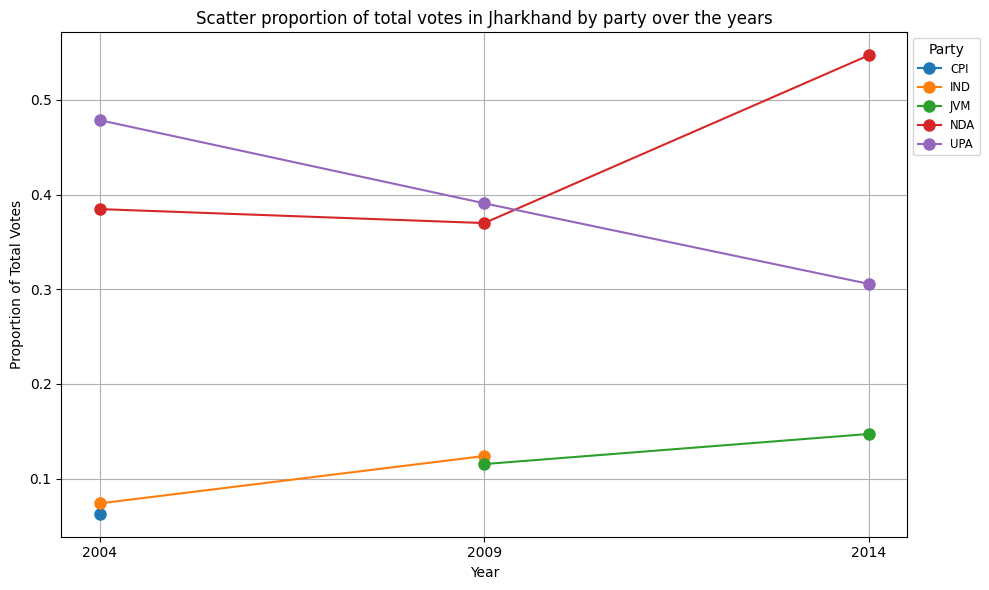

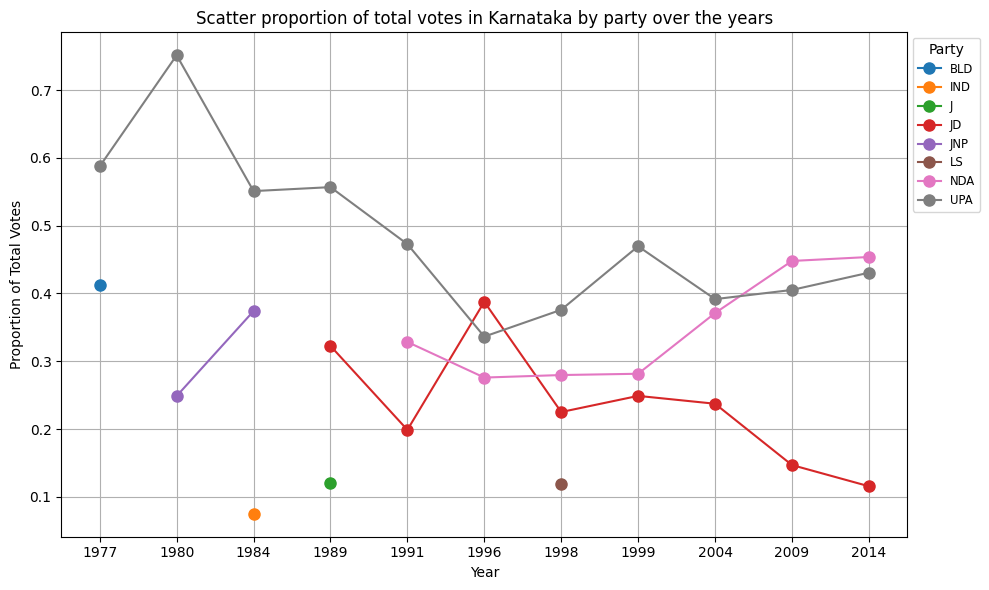

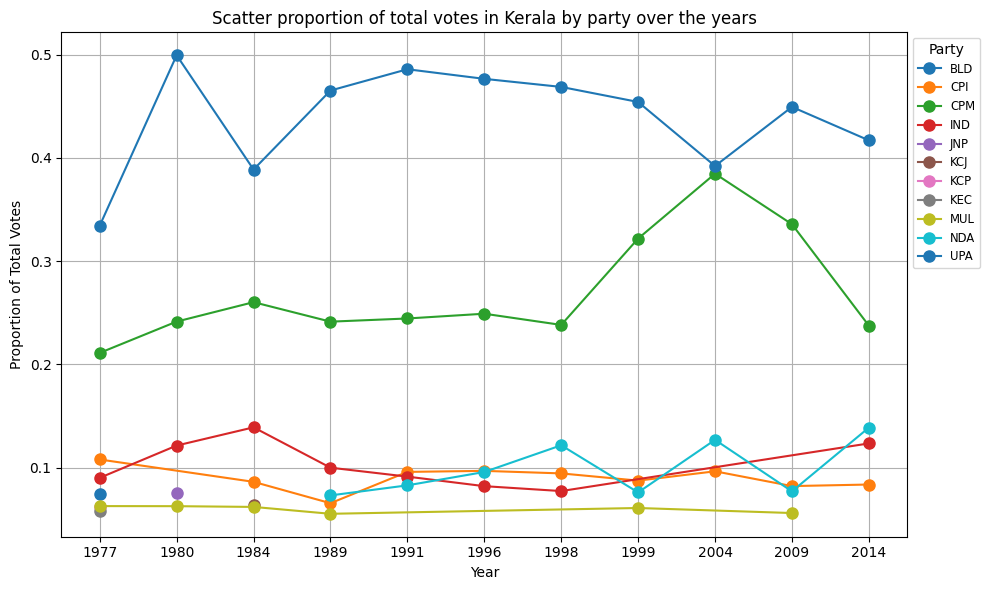

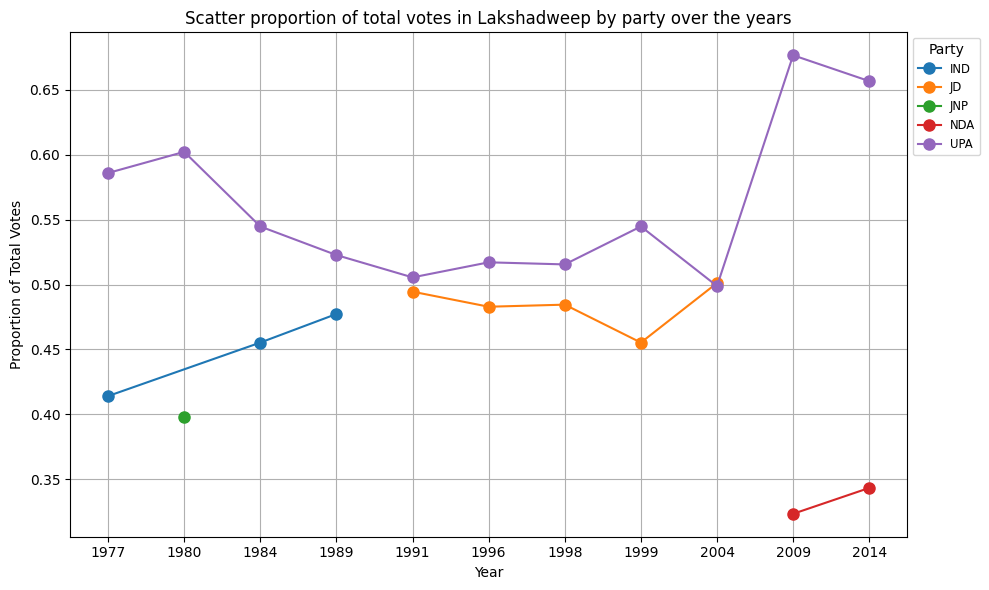

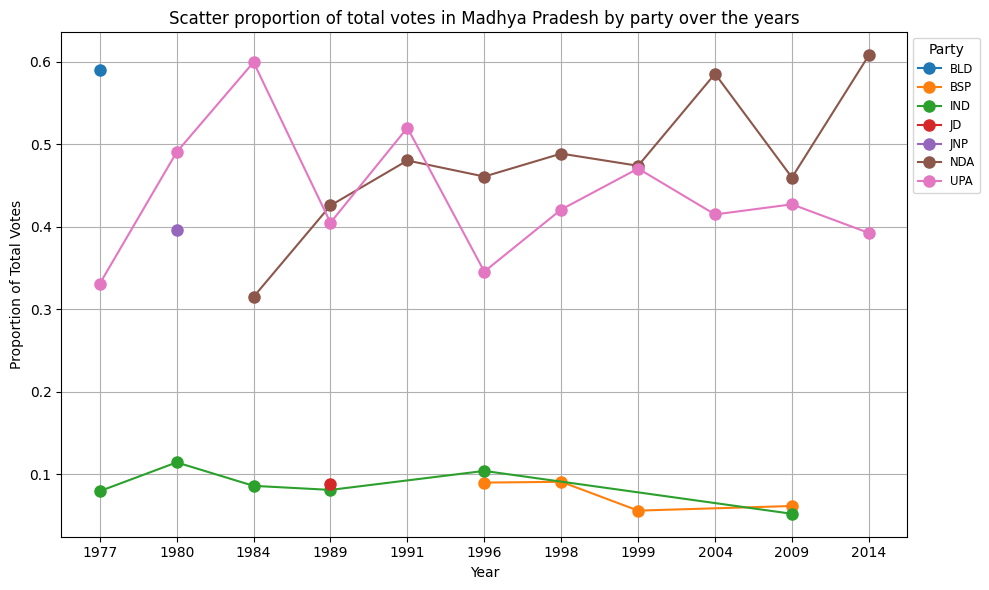

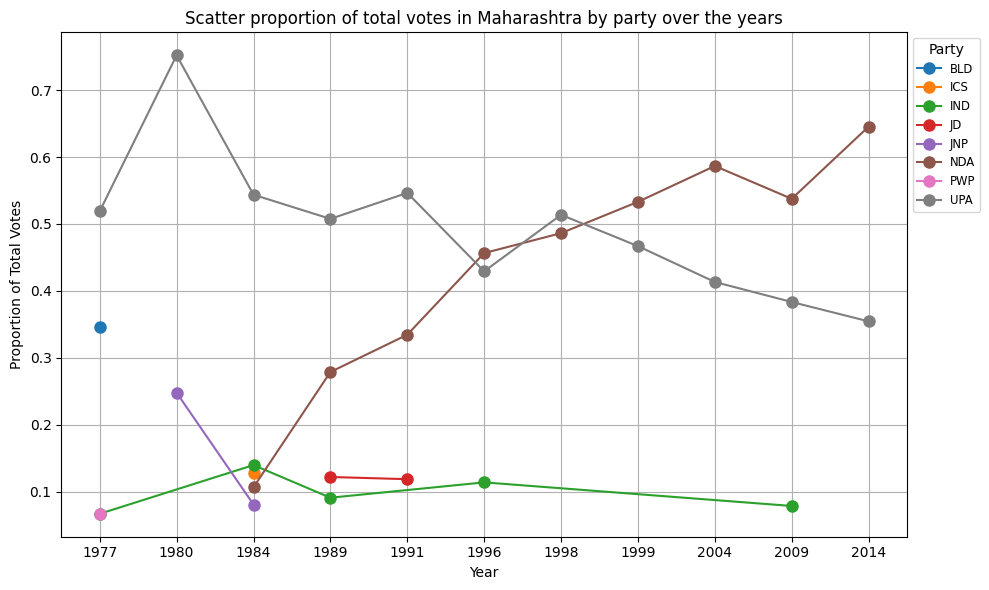

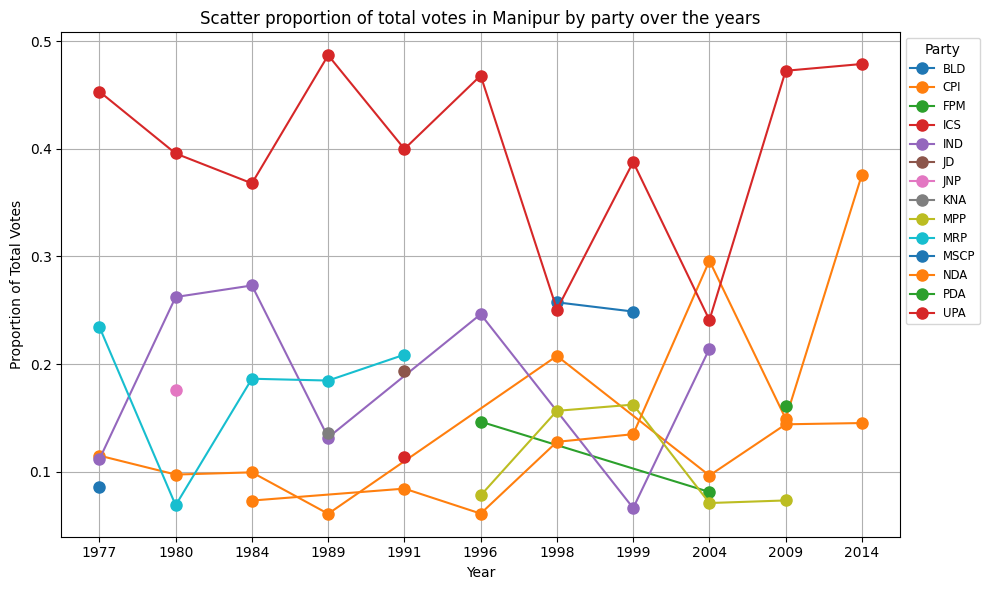

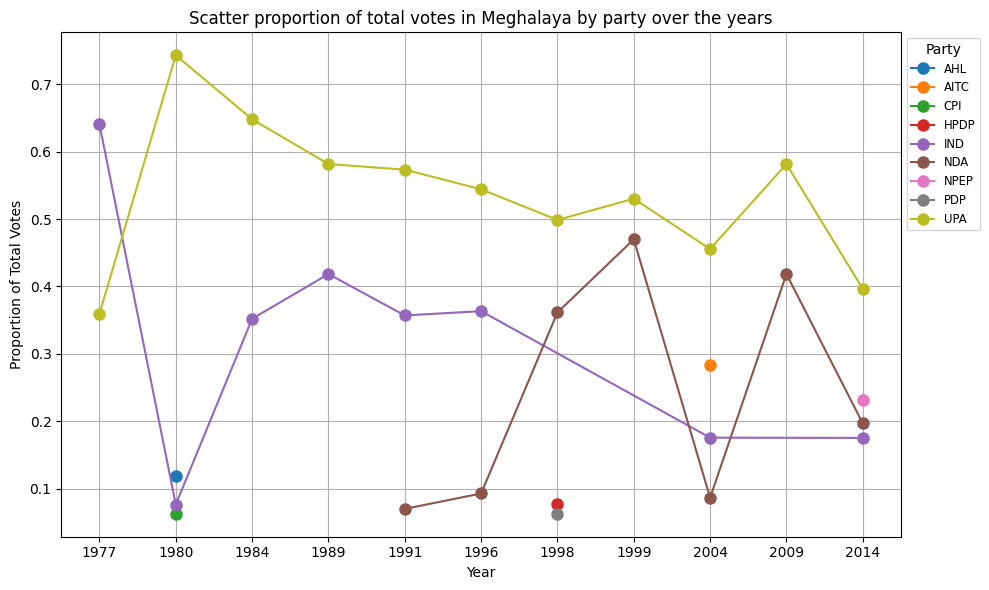

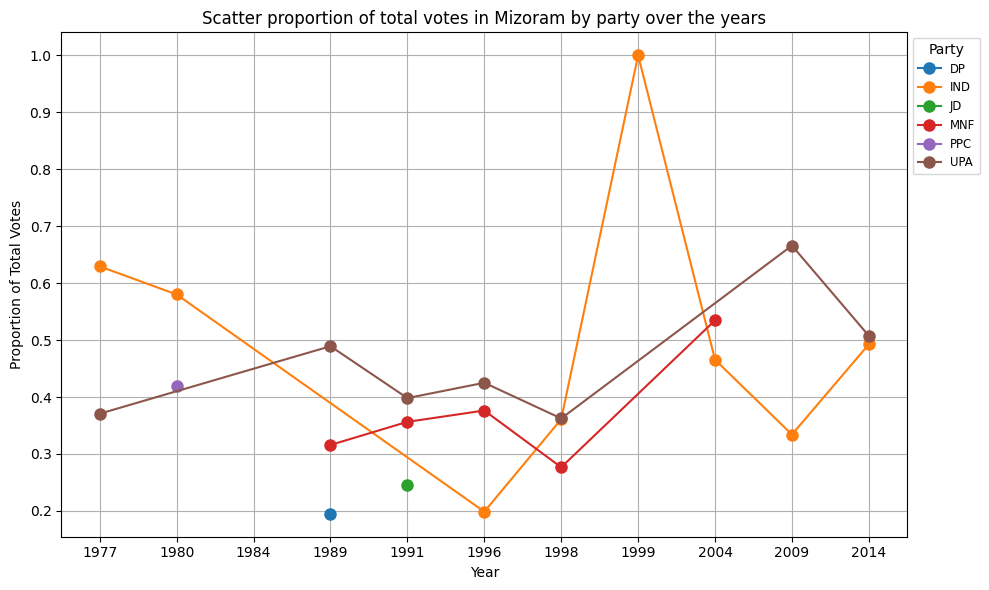

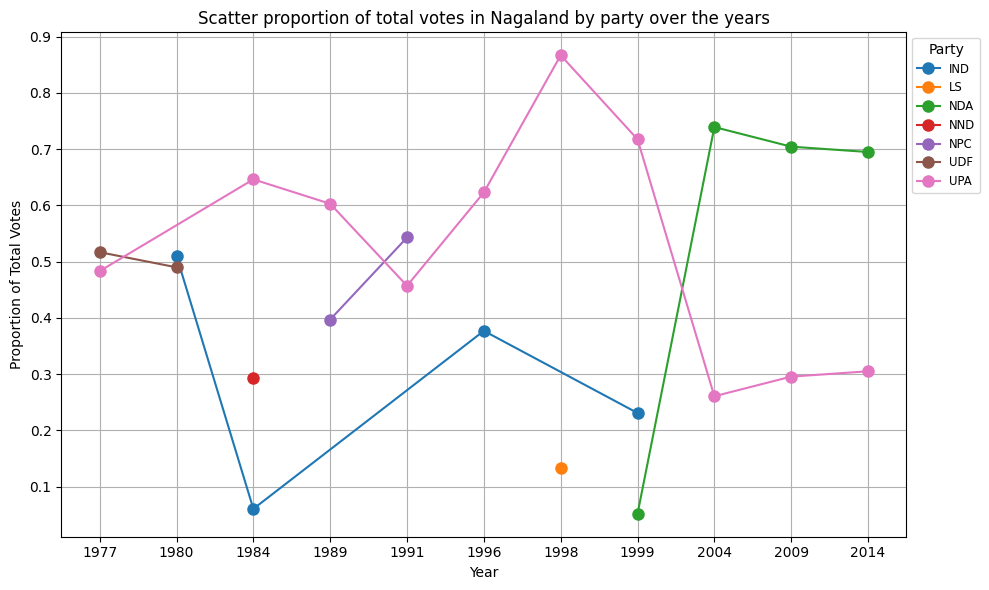

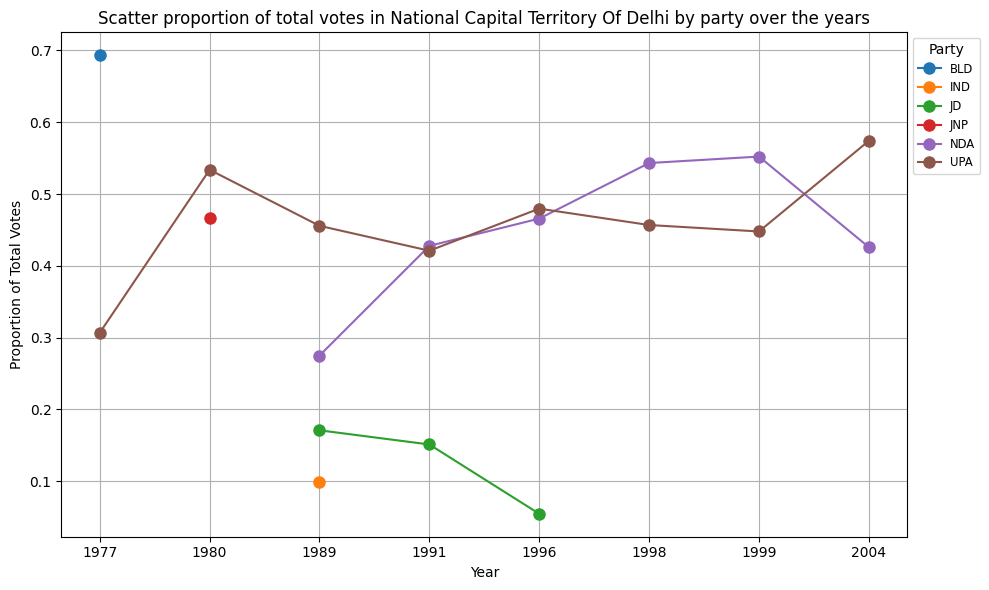

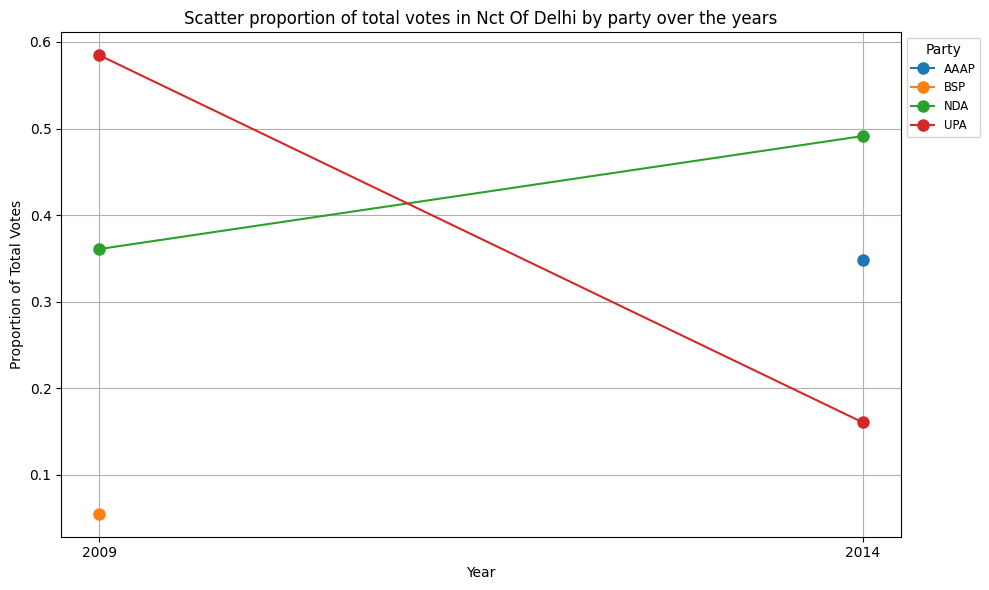

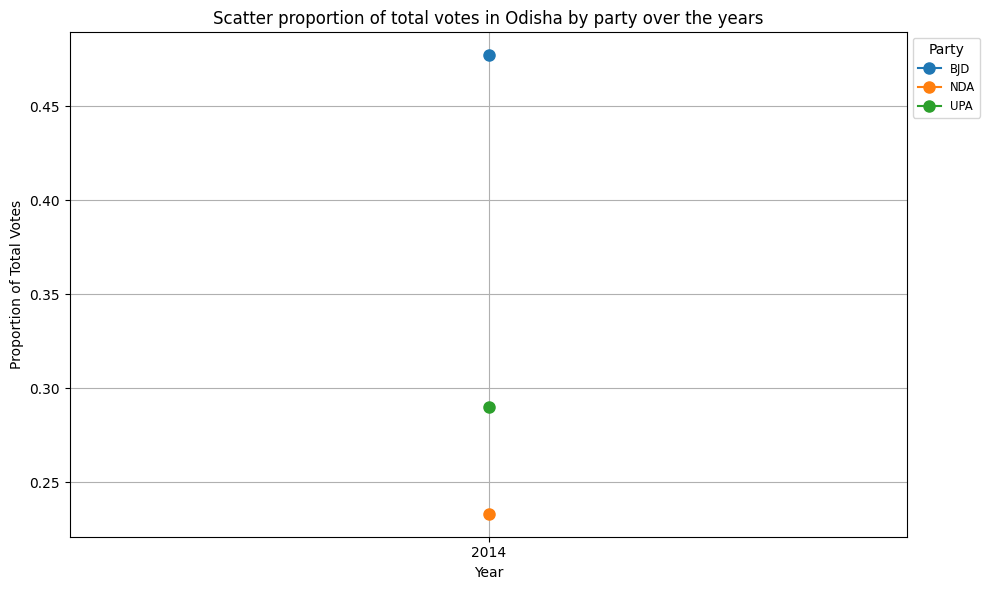

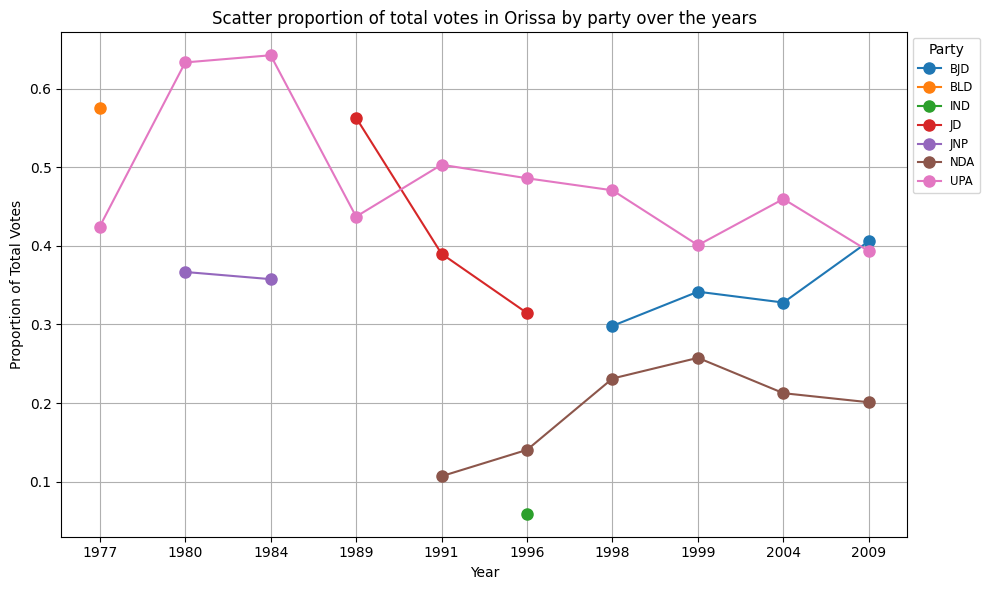

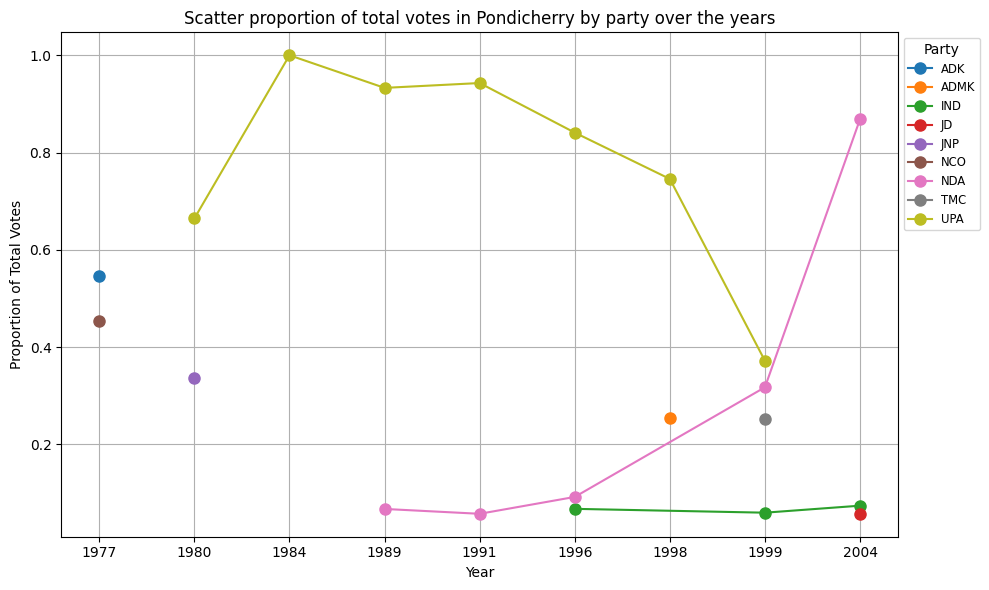

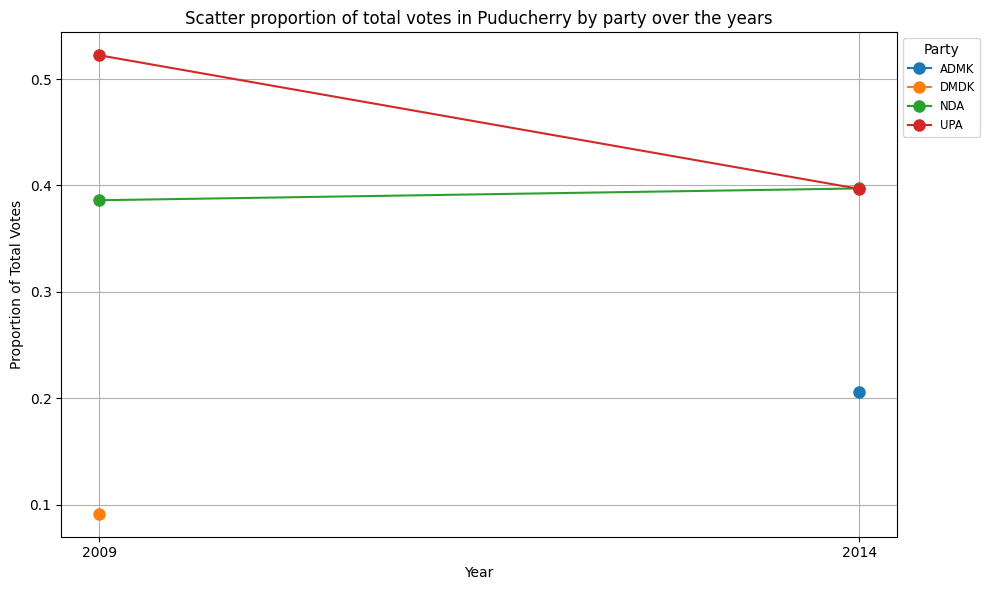

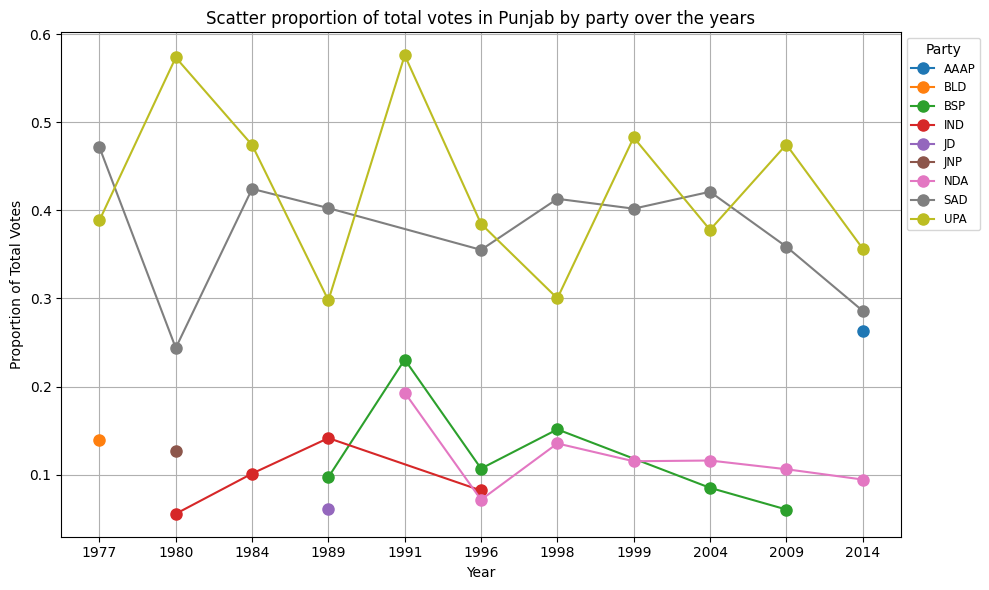

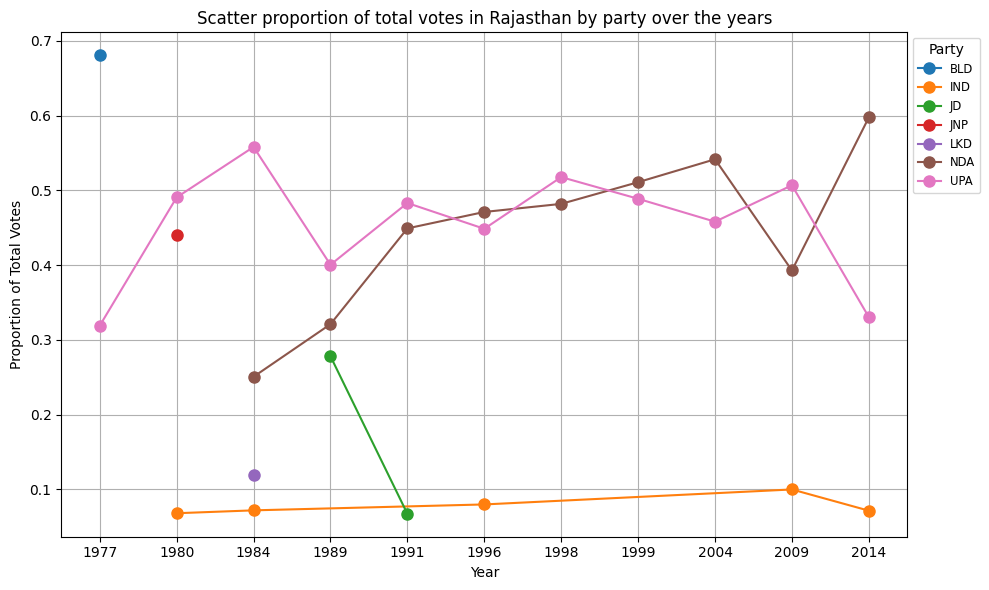

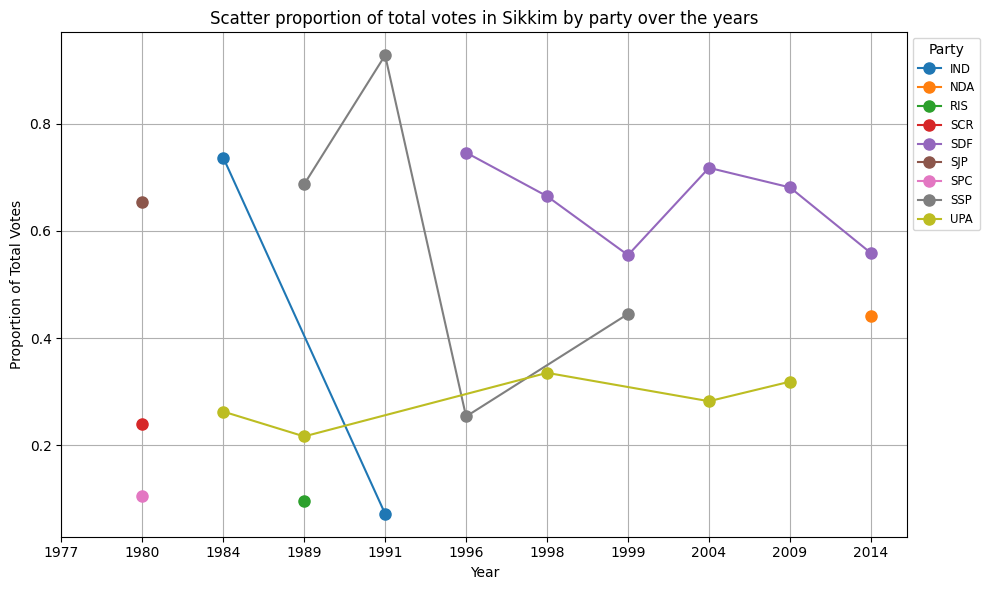

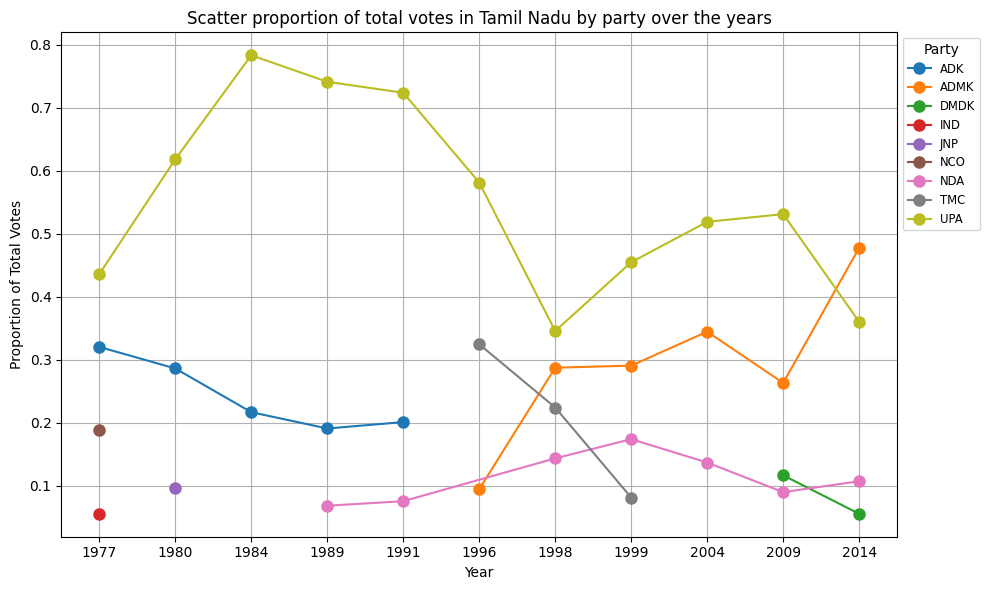

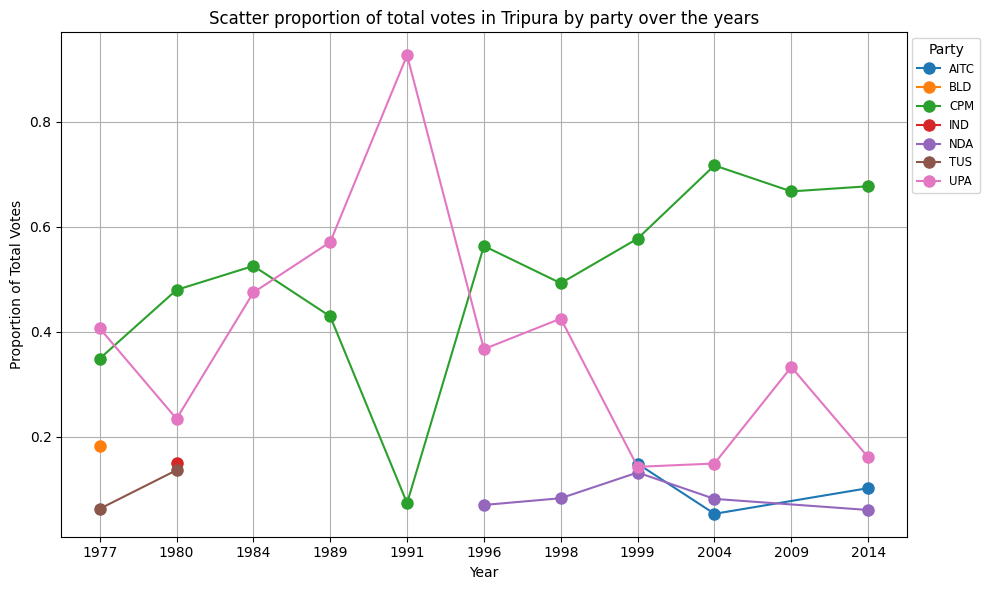

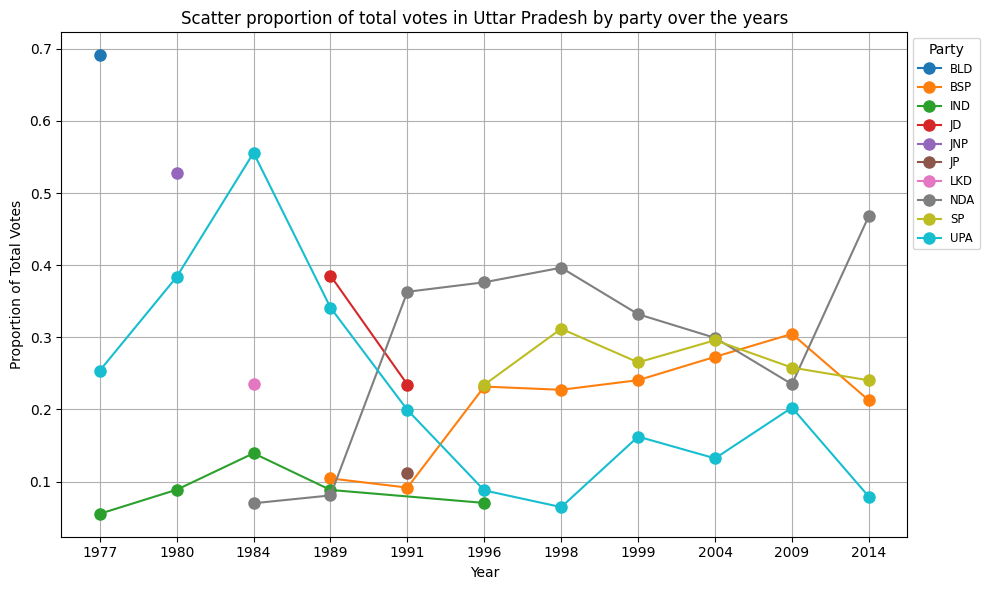

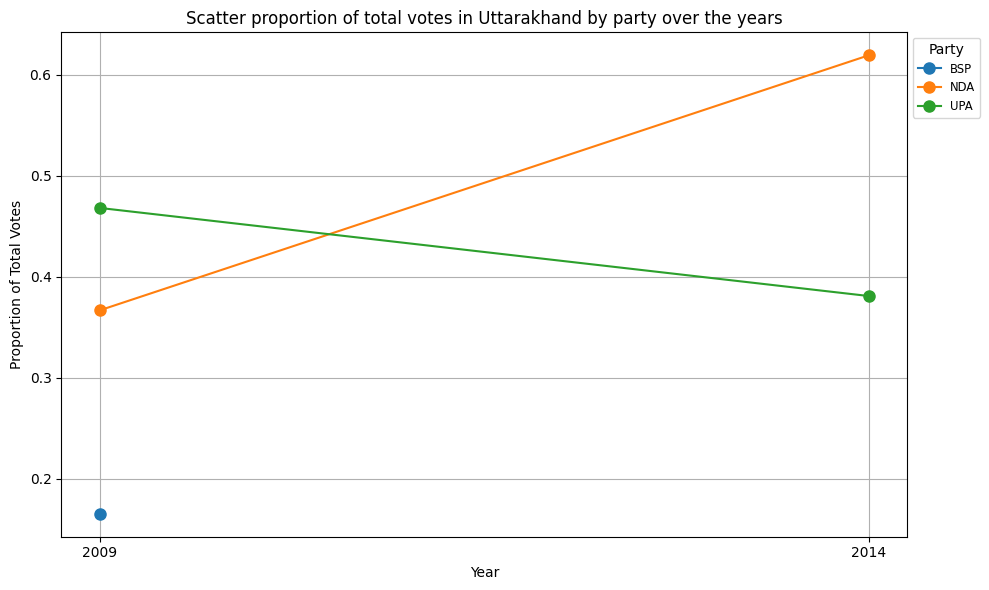

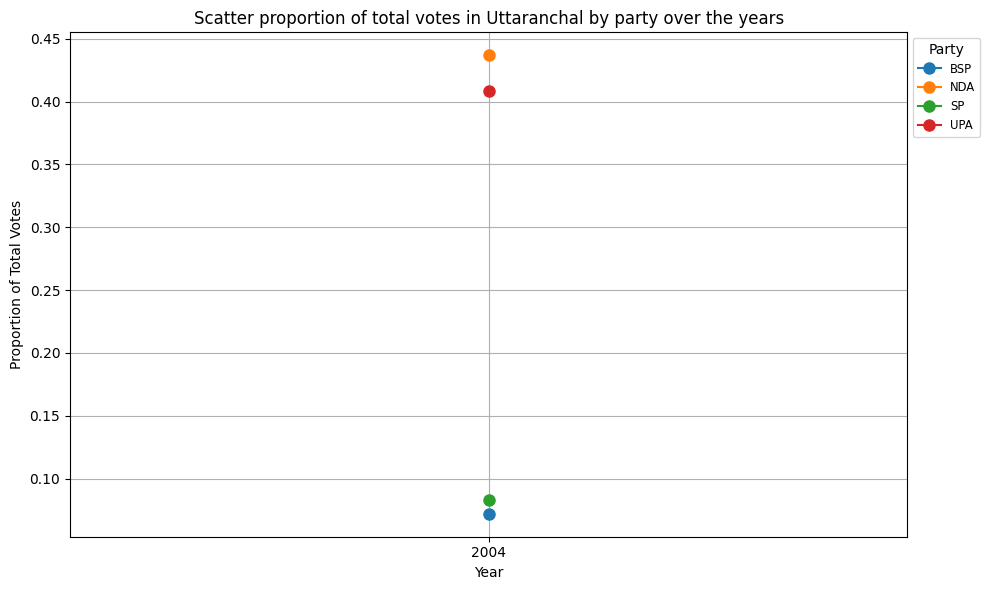

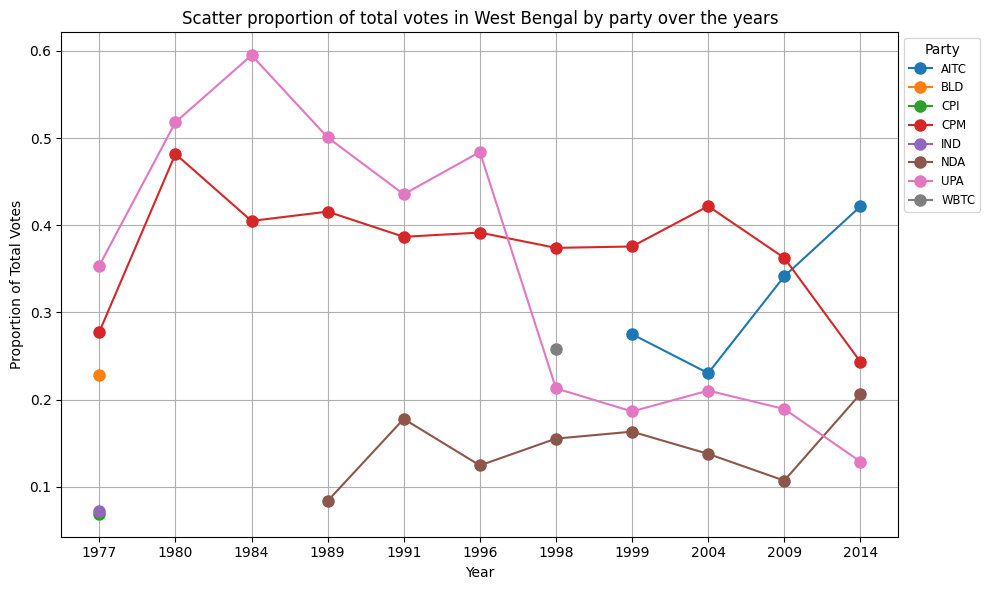

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter_party_ratios_by_state(aggregated_data, state):
    years = sorted(aggregated_data[state].keys())

    # Mapping of index positions to years
    year_mapping = {i: str(year) for i, year in enumerate(years)}

    # Dynamically determine the parties present in the state data
    parties = set()
    for year in years:
        parties.update(aggregated_data[state][year].keys())
    parties_order = sorted(parties)

    # Initialize a dict to hold the ratios for each party
    ratios_per_party = {party: [] for party in parties_order}
    year_labels_per_party = {party: [] for party in parties_order}  # To store indices for plotting

    # Populate the ratios for each party and each year
    for index, year in enumerate(years):
        year_total = sum(votes for _, votes in aggregated_data[state][year].values())

        for party in parties_order:
            party_data = aggregated_data[state][year].get(party, (0, 0))
            if party_data[1] > 0 and year_total > 0:
                ratio = party_data[1] / year_total
                ratios_per_party[party].append(ratio)
                year_labels_per_party[party].append(index)  # Use index instead of year

    # Create the scatter plot for each state
    fig, ax = plt.subplots(figsize=(10, 6))

    for party in parties_order:
        ax.plot(year_labels_per_party[party], ratios_per_party[party], marker='o', linestyle='-', label=party, markersize=8)

    ax.set_xlabel('Year')
    ax.set_ylabel('Proportion of Total Votes')
    ax.set_title(f'Scatter proportion of total votes in {state} by party over the years')
    ax.legend(title='Party', loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

    # Set custom x-ticks using the mapping
    ax.set_xticks(list(year_mapping.keys()))
    ax.set_xticklabels(list(year_mapping.values()))

    plt.tight_layout()
    plt.grid(True)
    ax.set_axisbelow(True)
    # plt.savefig(fname='EXP-3-2', dpi=1000)
    plt.show()

state_list =  ['Andaman & Nicobar Islands', 'Andhra Pradesh', 'Arunachal Pradesh',
       'Assam', 'Bihar', 'Chandigarh', 'Chattisgarh', 'Chhattisgarh',
       'Dadra & Nagar Haveli', 'Daman & Diu', 'Delhi', 'Goa', 
       'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu & Kashmir', 'Jharkhand', 
       'Karnataka', 'Kerala', 'Lakshadweep', 'Madhya Pradesh', 'Maharashtra',
       'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
       'National Capital Territory Of Delhi', 'Nct Of Delhi', 'Odisha',
       'Orissa', 'Pondicherry', 'Puducherry', 'Punjab', 'Rajasthan',
       'Sikkim', 'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'Uttarakhand',
       'Uttaranchal', 'West Bengal']
   
for state in state_list:
    plot_scatter_party_ratios_by_state(results, state)


In [10]:
import pandas as pd

import csv

# import pandas as pd
# df = pd.DataFrame(list())
# df.to_csv('result_final.csv')

import csv

# Nested dictionary as described
data = results

# Specify the filename
filename = 'Election_Data.csv'

# Field names for CSV
fields = ['State', 'Year', 'Party', 'Votes', 'Ratio']

# Writing to CSV
with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()
    
    # Process each state
    for state, years in data.items():
        # Process each year within the state
        for year, parties in years.items():
            # Process each party within the year
            for party, values in parties.items():
                # Prepare a row for each party's data
                row = {
                    'State': state,
                    'Year': year,
                    'Party': party,
                    'Votes': values[0],
                    'Ratio': values[1]
                }
                writer.writerow(row)

print("CSV file has been created:", filename)


CSV file has been created: Election_Data.csv


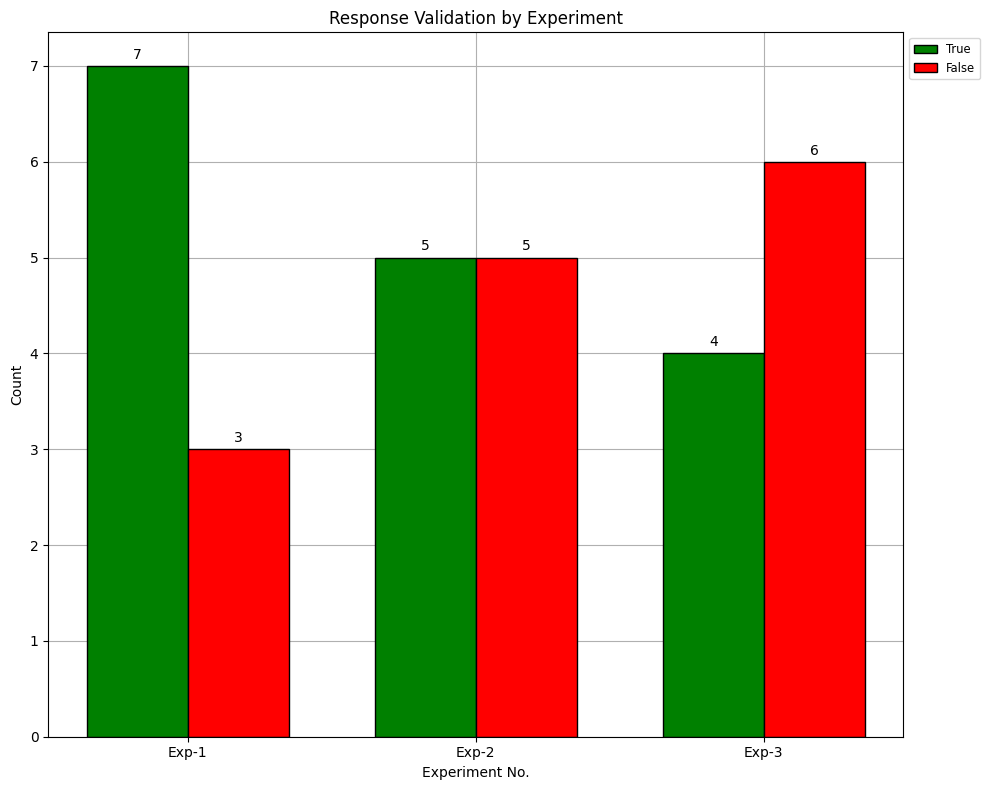

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Read the file
file_path = 'Responses.csv'
with open(file_path, 'r') as file:
    lines = file.readlines()

# Define ground truth for experiments
ground_truth = {
    "Pink Brown": "Pink Brown",
    "Blue Grey": "Blue Grey",
    "Brown Purple": "Brown Purple"
}

# Function to count matches by experiment with positions
def count_corrected_positioned_matches(rows, ground_truth):
    results = {key: {'correct': 0, 'wrong': 0} for key in ground_truth.keys()}
    position_map = {
        0: "Pink Brown",  # First position matches against Pink Brown
        1: "Blue Grey",   # Second position matches against Blue Grey
        2: "Brown Purple" # Third position matches against Brown Purple
    }
    for row in rows:
        items = row.split(',')
        for pos in position_map:
            if len(items) > pos:
                item = items[pos].strip()
                if item == ground_truth[position_map[pos]]:
                    results[position_map[pos]]['correct'] += 1
                else:
                    results[position_map[pos]]['wrong'] += 1
    return results

# Calculate the grouped results
grouped_results = count_corrected_positioned_matches(lines, ground_truth)

# Plot the results
experiment_labels = ["Exp-1", "Exp-2", "Exp-3"]  # Updated labels for the x-axis
correct_counts = [grouped_results[exp]['correct'] for exp in ground_truth.keys()]
incorrect_counts = [grouped_results[exp]['wrong'] for exp in ground_truth.keys()]
x = np.arange(len(experiment_labels))  # the label locations
fig, ax = plt.subplots(figsize=(10, 8))
width = 0.35  # the width of the bars
rects1 = ax.bar(x - width/2, correct_counts, width, label='True', color='green', edgecolor='black')
rects2 = ax.bar(x + width/2, incorrect_counts, width, label='False', color='red', edgecolor='black')
ax.set_xlabel('Experiment No.')
ax.set_ylabel('Count')
ax.set_title('Response Validation by Experiment')
ax.set_xticks(x)
ax.set_xticklabels(experiment_labels)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.grid(True)
ax.set_axisbelow(True)
plt.savefig(fname='Evalution', dpi=1000)

plt.show()
